<font size = 6>Predicting the risk of alzheimer's disease OASIS1 <font/>

$Ajinkya, Navya, Shibani, Chaitanya$





In [ ]:
# imports 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc
from sklearn.experimental import enable_iterative_imputer
from sklearn.inspection import permutation_importance
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [ ]:
#all paths
o1path = '/content/drive/MyDrive/DS2- Project/OASIS 1/oasis_cross-sectional.csv'

In [ ]:
oasis1 = pd.read_csv(o1path)
oasis1.head()

ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  \
0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743  1.306   
1  OAS1_0002_MR1   F    R   55   4.0  1.0  29.0  0.0  1147  0.810  1.531   
2  OAS1_0003_MR1   F    R   73   4.0  3.0  27.0  0.5  1454  0.708  1.207   
3  OAS1_0004_MR1   M    R   28   NaN  NaN   NaN  NaN  1588  0.803  1.105   
4  OAS1_0005_MR1   M    R   18   NaN  NaN   NaN  NaN  1737  0.848  1.010   

   Delay  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN

## EDA

In [ ]:
oasis1_cs = oasis1.copy()
oasis1_cs.head()
print(f'Shape of the oasis 1 data is {oasis1_cs.shape}')

Shape of the oasis 1 data is (436, 12)


### Understanding the subjects in the data better

#### Histogram of gender in the data

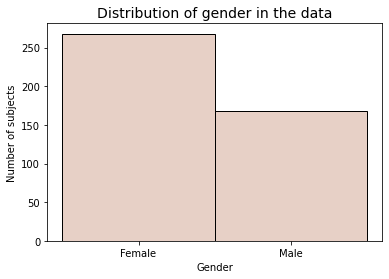

In [ ]:
sns.histplot(data=oasis1_cs, x='M/F', color='#e0c1b3')
plt.xticks([0,1],['Female', 'Male'])
plt.xlabel('Gender')
plt.ylabel('Number of subjects')
plt.title('Distribution of gender in the data', fontsize=14)
plt.show()

The data contains more number of female subjects than the male subjects. This could be because females are more likely to be diagnosed with Alziehmers.

#### Pie chart of dominant hand

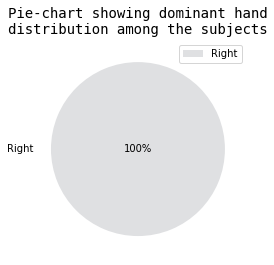

In [ ]:
plt.pie(oasis1_cs['Hand'].value_counts(), labels=['Right'], autopct='%.0f%%',
        pctdistance=0, colors=['#dfe0e2'], labeldistance=1.2)
plt.title('Pie-chart showing dominant hand\ndistribution among the subjects', fontsize=14, fontname='monospace')
plt.legend()
plt.show()

All subjects in the data are right handed. The right or left hand dominance corresponds to  contralateral control via brain and localisation of functions. So, we can speculate that OASIS 1 only contains right handed subjects to ensure that the processing the MRI images remains the same.<br/>
This feature can be removed because this doesn't affect the model's predictions.

#### Histogram of Age w/ gender

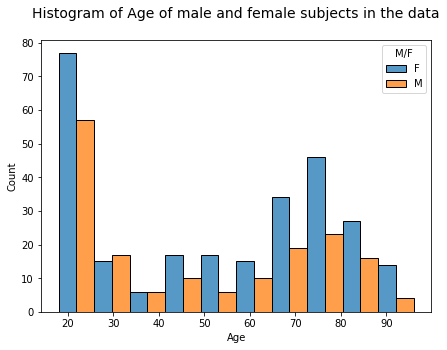

In [ ]:
fig=plt.figure(figsize=(7,5))
sns.histplot(data=oasis1_cs, x='Age', hue='M/F', multiple='dodge')

plt.title('Histogram of Age of male and female subjects in the data\n', fontsize=14)
plt.show()

Age of both female and male subjects is distributed fairly.

#### Distribution of Socio-economic status
Assessed by the Hollingshead Index
of Social Position and classified
into categories from 1 (highest
status) to 5 (lowest status)

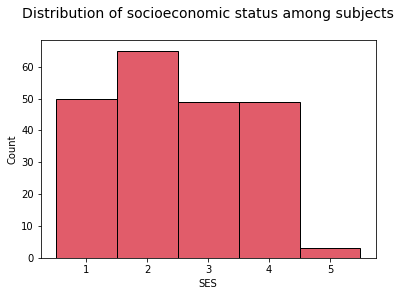

In [ ]:
sns.histplot(data=oasis1_cs, x='SES', discrete=True, color ='#d72638')
plt.title('Distribution of socioeconomic status among subjects\n', fontsize=14)
plt.show()

The data does not contain enough subjects with lowest socio-economic status

#### Distribution of Education
Years of education scaled to 1 (highest) to 5 (lowest)

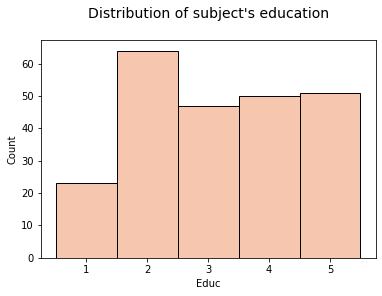

In [ ]:
sns.histplot(data=oasis1_cs, x='Educ', discrete=True, color = '#f4b393')
plt.title('Distribution of subject\'s education\n', fontsize=14)
plt.show(fig)

The Education of subjects is fairly distributed among the data. The data containly comparitively lower number of subjects with highest education level.

#### Relation between Education and Socio-economic status of subjects.

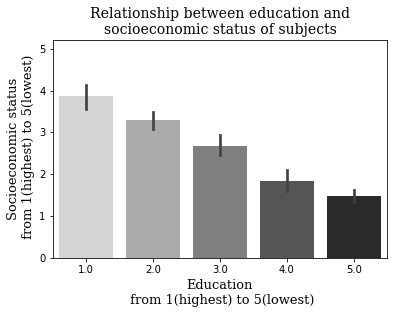

In [ ]:
sns.barplot(data=oasis1_cs, x='Educ', y='SES', palette='gray_r')
plt.yticks(range(0,6))
plt.ylim([0,5.2])
plt.xlabel('Education\n from 1(highest) to 5(lowest)', fontsize=13, fontname='serif')
plt.ylabel('Socioeconomic status\n from 1(highest) to 5(lowest)', fontsize=13, fontname='serif')
plt.title('Relationship between education and\nsocioeconomic status of subjects', fontsize=14, fontname='serif')
plt.show()

We can infer from the plot above that the education level of the subjects correlates with their socio-economic status.

### Descriptive statistics of the data

In [ ]:
oasis1_cs.describe()

Age        Educ         SES       MMSE         CDR         eTIV  \
count  436.000000  235.000000  216.000000  235.00000  235.000000   436.000000   
mean    51.357798    3.178723    2.490741   27.06383    0.285106  1481.919725   
std     25.269862    1.311510    1.120593    3.69687    0.383405   158.740866   
min     18.000000    1.000000    1.000000   14.00000    0.000000  1123.000000   
25%     23.000000    2.000000    2.000000   26.00000    0.000000  1367.750000   
50%     54.000000    3.000000    2.000000   29.00000    0.000000  1475.500000   
75%     74.000000    4.000000    3.000000   30.00000    0.500000  1579.250000   
max     96.000000    5.000000    5.000000   30.00000    2.000000  1992.000000   

             nWBV         ASF     Delay  
count  436.000000  436.000000  20.00000  
mean     0.791670    1.198894  20.55000  
std      0.059937    0.128682  23.86249  
min      0.644000    0.881000   1.00000  
25%      0.742750    1.111750   2.75000  
50%      0.809000    1.190000  11.00000  
75%      0.842000    1.284250  30.75000  
max      0.893000    1.563000  89.00000

In [ ]:
## tbl_report function re used from exercises

from IPython.display import display, HTML

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )
def tbl_report(tbl, cols=None, card=10):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='NA'
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return pretty_print(df[cols])
    return pretty_print(df)

In [ ]:
tbl_report(oasis1_cs, cols=['dtype', 'nulls', 'num_uniques', 'value_counts'])

Table Shape (436, 12)


#### Checking where the null values are

In [ ]:
oasis1_cs[(oasis1_cs.SES.isna() & oasis1_cs.Educ.isna() & oasis1_cs.MMSE.isna() & oasis1_cs.CDR.isna())].shape

(201, 12)

201 observations have *Education*, *Socioeconomic status*, *MMSE*, *CDR* features as null all together.

We can remove these observations mainly because the target *CDR* is null in these observations.

In [ ]:
#checking feature wise null values
oasis1_cs.isna().sum()

ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64

In [ ]:
#removing the observations with 
o1_no_CDR_null = oasis1_cs[oasis1_cs['CDR'].notna()].copy()

In [ ]:
o1_no_CDR_null.head()

ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  \
0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743  1.306   
1  OAS1_0002_MR1   F    R   55   4.0  1.0  29.0  0.0  1147  0.810  1.531   
2  OAS1_0003_MR1   F    R   73   4.0  3.0  27.0  0.5  1454  0.708  1.207   
8  OAS1_0010_MR1   M    R   74   5.0  2.0  30.0  0.0  1636  0.689  1.073   
9  OAS1_0011_MR1   F    R   52   3.0  2.0  30.0  0.0  1321  0.827  1.329   

   Delay Dementia  
0    NaN   Absent  
1    NaN   Absent  
2    NaN  Present  
8    NaN   Absent  
9    NaN   Absent

### Understanding features relation with MMSE

In [ ]:
# Creating a new column for presence of Dementia
o1_no_CDR_null['Dementia'] = o1_no_CDR_null['CDR'].apply(lambda x: 'Present' if x !=0 else 'Absent')

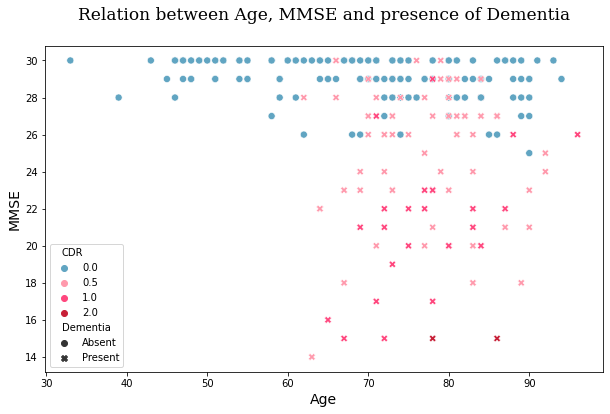

In [ ]:
fig = plt.figure(figsize = (10,6))
sns.scatterplot(data = o1_no_CDR_null, x = 'Age', y = 'MMSE', hue = 'CDR', palette = ['#61a5c2', '#ff99ac', '#ff477e', '#c71f37'], style = 'Dementia', s = 50)
plt.title('Relation between Age, MMSE and presence of Dementia\n', fontsize = 17, fontname = 'serif')
plt.xlabel('Age', fontsize = 14)
plt.ylabel('MMSE', fontsize = 14)
plt.show()

We can observe that individuals with lower MMSE have dementia of some mildness irrespective of age of the individual.

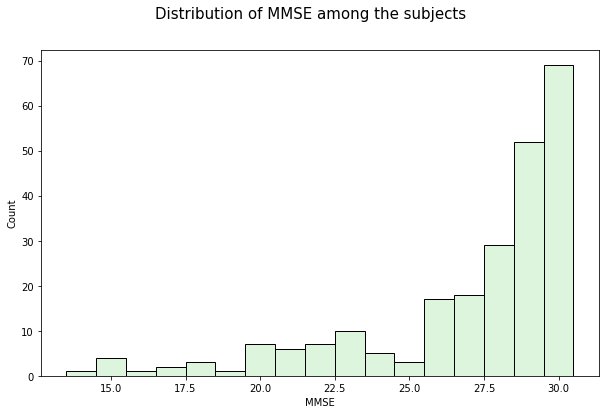

In [ ]:
fig = plt.figure(figsize = (10,6))
sns.histplot(data = o1_no_CDR_null, x='MMSE', discrete = True, color = '#d4f2d2')
fig.suptitle('Distribution of MMSE among the subjects', fontsize = 15)
plt.show(fig)

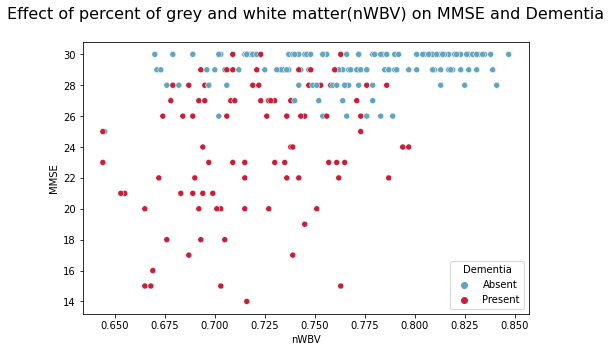

In [ ]:
fig = plt.figure(figsize = (8,5))
sns.scatterplot(data = o1_no_CDR_null, x = 'nWBV', y = 'MMSE', hue='Dementia', palette =['#61a5c2','#c71f37'])
plt.title('Effect of percent of grey and white matter(nWBV) on MMSE and Dementia\n', fontsize = 16)
plt.show()

### Understanding features relation with eTIV (Total intracranial Volume %)

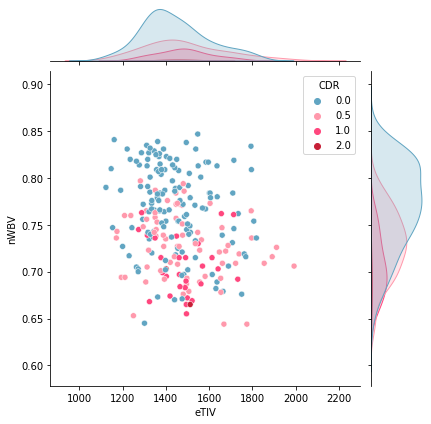

In [ ]:
sns.jointplot(data = o1_no_CDR_null, x = 'eTIV', y = 'nWBV', hue = 'CDR', palette = ['#61a5c2', '#ff99ac', '#ff477e', '#c71f37'])
plt.show()

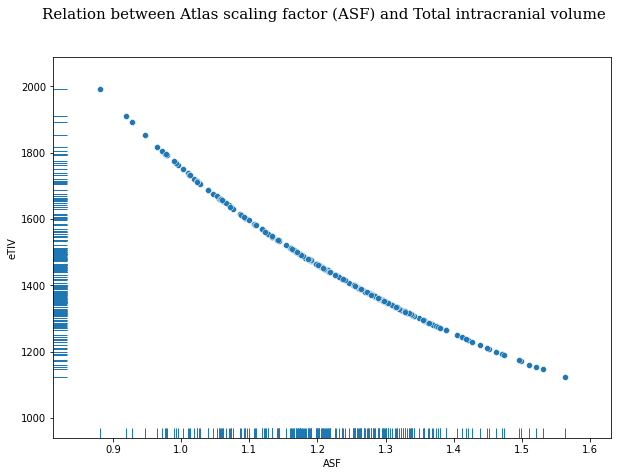

In [ ]:
fig = plt.figure(figsize = (10,7))
sns.scatterplot(data = o1_no_CDR_null, x = 'ASF', y = 'eTIV')
sns.rugplot(data = o1_no_CDR_null, x = 'ASF', y = 'eTIV')
fig.suptitle('Relation between Atlas scaling factor (ASF) and Total intracranial volume', fontsize = 15, fontname = 'Serif')
plt.show(fig)

The eTIV (Total intracranial volume) and ASF (Atlas scaling factor) are negatively related.

From the paper,
>estimated total intracranial volume (eTIV) was
computed by scaling the manually measured intracranial
volume of the atlas by the determinant of the affine
transform connecting each individual to the atlas.

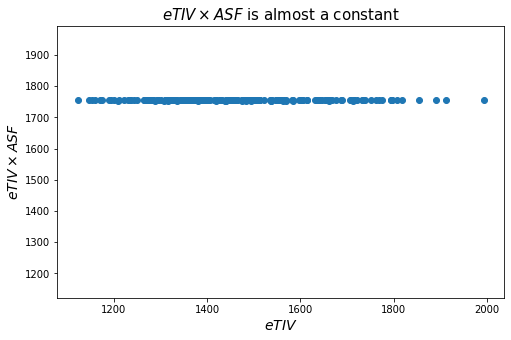

In [ ]:
fig = plt.figure(figsize = (8,5))
plt.scatter(o1_no_CDR_null['eTIV'], o1_no_CDR_null['eTIV']*o1_no_CDR_null['ASF'])
plt.ylim([o1_no_CDR_null['eTIV'].min()-1, o1_no_CDR_null['eTIV'].max()+1])
plt.xlabel('$eTIV$', fontsize = 14)
plt.ylabel(r'$eTIV \times ASF$', fontsize = 14)
plt.title(r'$eTIV \times ASF$ is almost a constant', fontsize = 15 )
plt.show()

The product of eTIV and ASF seem to be almost a constant. This could possibly be because both measures are related to the brain volume / imaging data. We would need to delve further to derive more pointed insights. 

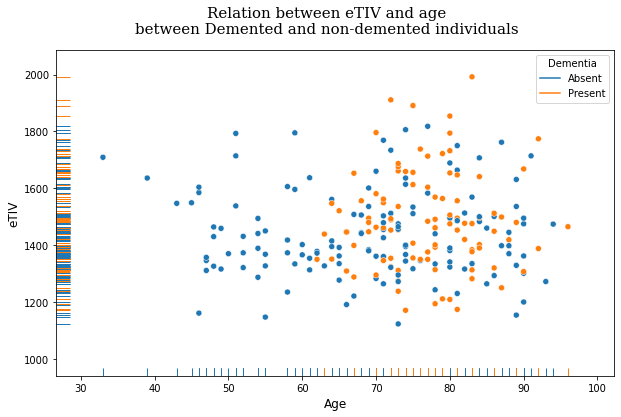

In [ ]:
fig = plt.figure(figsize = (10,6))
sns.scatterplot(data = o1_no_CDR_null, x = 'Age', y = 'eTIV', hue = 'Dementia')
sns.rugplot(data = o1_no_CDR_null, x = 'Age', y = 'eTIV', hue = 'Dementia')
plt.xlabel('Age', fontsize =12)
plt.ylabel('eTIV', fontsize =12)
fig.suptitle('Relation between eTIV and age\nbetween Demented and non-demented individuals', fontsize = 15, fontname = 'serif')
plt.show(fig)

### Understanding features relation with nWBV

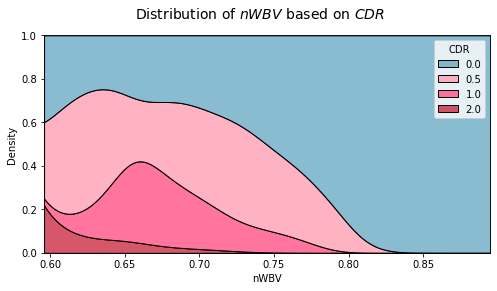

In [ ]:
fig = plt.figure(figsize = (8,4))
sns.kdeplot(data = o1_no_CDR_null, x = 'nWBV', hue = 'CDR', palette =['#61a5c2', '#ff99ac', '#ff477e', '#c71f37'], multiple = 'fill')

fig.suptitle('Distribution of $nWBV$ based on $CDR$', fontsize = 14)
plt.show(fig)

The distribution of nWBV shifts to the left and downwards as the CDR increases.(Density of nWBV is decreasing).<br/>
This is expected as higher CDR indicates severity of Dementia.

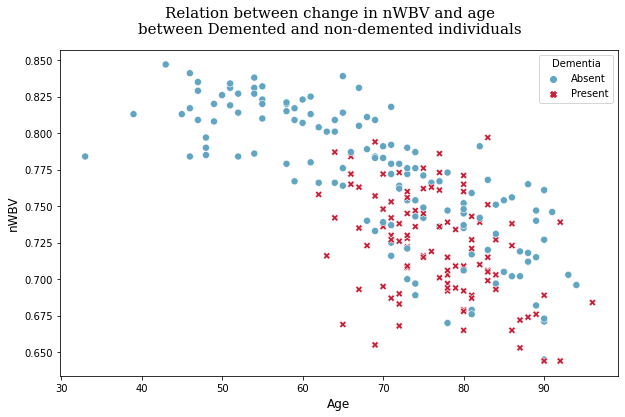

In [ ]:
fig = plt.figure(figsize = (10,6))
sns.scatterplot(data = o1_no_CDR_null, x = 'Age', y = 'nWBV', hue = 'Dementia', style = 'Dementia', s = 50, palette = ['#61a5c2','#c71f37'])
plt.xlabel('Age', fontsize =12)
plt.ylabel('nWBV', fontsize =12)
fig.suptitle('Relation between change in nWBV and age\nbetween Demented and non-demented individuals', fontsize = 15, fontname = 'serif')
plt.show(fig)

nWBV of people with dementia doesn't follow the usual relation between Age and nWBV in non-demented people. We can see a dip in nWBV for demented individuals.

### Correlation heatmap of features with the target variable (CDR)

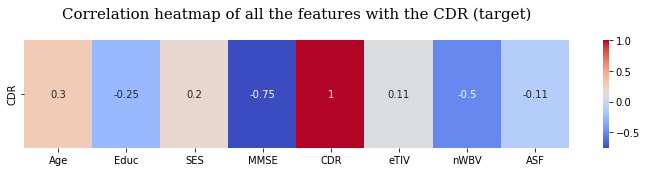

In [ ]:
fig = plt.figure(figsize = (10,2.5), tight_layout = True)
sns.heatmap(data =pd.DataFrame(o1_no_CDR_null.drop(columns = ['ID', 'Hand', 'Delay', 'Dementia']).corr().loc['CDR',:]).T, annot = True, cmap = 'coolwarm')
plt.title('Correlation heatmap of all the features with the CDR (target)\n', fontsize = 15, fontname = 'serif')
plt.show(fig)

`MMSE` (Mini-Mental State Examination score) correlates highest with the `CDR` (Clinical Dementia Rating). This could be because `MMSE` score is used to calculate `CDR` along with MRI images and Clinician's experience with the subject.

## Preparing the data 
Dealing with null values

Checking where null values have occurred. ---> needs better wording

As the paper states, 
>  Twenty subjects in
their twenties were imaged on a second occasion within
90 days of their initial session to provide a means for
assessing reliability of data acquisition and analysis.

In [ ]:
oasis1[oasis1['Delay'].notna()].head()

ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  \
416  OAS1_0061_MR2   F    R   20   NaN  NaN   NaN  NaN  1757  0.845  0.999   
417  OAS1_0080_MR2   F    R   25   NaN  NaN   NaN  NaN  1605  0.841  1.093   
418  OAS1_0092_MR2   M    R   22   NaN  NaN   NaN  NaN  1457  0.835  1.205   
419  OAS1_0101_MR2   M    R   29   NaN  NaN   NaN  NaN  1501  0.835  1.169   
420  OAS1_0111_MR2   M    R   23   NaN  NaN   NaN  NaN  1714  0.861  1.024   

     Delay  
416    1.0  
417   20.0  
418    5.0  
419   64.0  
420    2.0

All these subjects are imaged for a second time with in 90 days of their intial session. Since these are for the reliability of data acquisition, it is safe to assume that `Educ`, `SES`, `MMSE` and `CDR` will not be changed since their intial assessment.

In [ ]:
print(f"There are {oasis1[(oasis1['Educ'].isna() & oasis1['SES'].isna() & oasis1['MMSE'].isna() & oasis1['CDR'].isna() & oasis1['Delay'].isna())].shape[0]} single visit individuals (observations) with all of Education, socio-economic status, MMSE and CDR as null values")

There are 181 single visit individuals (observations) with all of Education, socio-economic status, MMSE and CDR as null values


Since these observations don't have `CDR` (Clinical dementia Rating) which is a target variable, we can drop these.

In [ ]:
oasis1_cleaned_v1 = oasis1[~(oasis1['Educ'].isna() & oasis1['SES'].isna() & oasis1['MMSE'].isna() & oasis1['CDR'].isna())]
print(f"Shape of the data after removing observations with null values in target variables {oasis1_cleaned_v1.shape}")

Shape of the data after removing observations with null values in target variables (235, 12)


In [ ]:
oasis1_cleaned_v1.isna().sum()

ID         0
M/F        0
Hand       0
Age        0
Educ       0
SES       19
MMSE       0
CDR        0
eTIV       0
nWBV       0
ASF        0
Delay    235
dtype: int64

There are still some observations with null values in socio-economic status feature, we can impute them.<br/>
`Delay` feature contains number of days after which a subject {took mri} for a second time.

Dropping `Hand` and `Delay`

In [ ]:
oasis1_cleaned_v1 =  oasis1_cleaned_v1.drop(columns = ['Delay', 'Hand']).copy()

NOTE to self: try logistic regression to predict SES - using only Age, Gender, Educ

In [ ]:
df_ses = oasis1_cleaned_v1[['M/F', 'Age', 'Educ', 'SES']]
df_ses.head()

M/F  Age  Educ  SES
0   F   74   2.0  3.0
1   F   55   4.0  1.0
2   F   73   4.0  3.0
8   M   74   5.0  2.0
9   F   52   3.0  2.0

In [ ]:
df_ses.dtypes

M/F      object
Age       int64
Educ    float64
SES     float64
dtype: object

In [ ]:
# df_ses['Educ'] = pd.Categorical(df_ses['Educ'])
# df_ses['SES'] = pd.Categorical(df_ses['SES'])
df_ses['M/F'] = df_ses['M/F'].apply(lambda x: {'M':0, 'F':1}[x]) #.astype('category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_ses.dtypes

M/F       int64
Age       int64
Educ    float64
SES     float64
dtype: object

In [ ]:
df_ses.head()

M/F  Age  Educ  SES
0    1   74   2.0  3.0
1    1   55   4.0  1.0
2    1   73   4.0  3.0
8    0   74   5.0  2.0
9    1   52   3.0  2.0

In [ ]:
df_ses.dtypes

M/F       int64
Age       int64
Educ    float64
SES     float64
dtype: object

In [ ]:
mice_imp = IterativeImputer(estimator = LogisticRegression(max_iter = 100000))
oasis1_cleaned = oasis1_cleaned_v1.copy()
oasis1_cleaned['SES'] =  mice_imp.fit_transform(df_ses)[:, 3]

In [ ]:
oasis1_cleaned.shape

(235, 10)

In [ ]:
oasis1_cleaned.head()

ID M/F  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF
0  OAS1_0001_MR1   F   74   2.0  3.0  29.0  0.0  1344  0.743  1.306
1  OAS1_0002_MR1   F   55   4.0  1.0  29.0  0.0  1147  0.810  1.531
2  OAS1_0003_MR1   F   73   4.0  3.0  27.0  0.5  1454  0.708  1.207
8  OAS1_0010_MR1   M   74   5.0  2.0  30.0  0.0  1636  0.689  1.073
9  OAS1_0011_MR1   F   52   3.0  2.0  30.0  0.0  1321  0.827  1.329

In [ ]:
oasis1_cleaned.isna().sum()

ID      0
M/F     0
Age     0
Educ    0
SES     0
MMSE    0
CDR     0
eTIV    0
nWBV    0
ASF     0
dtype: int64

Cleaned/imputed all the null values in the data.

### Checking and correcting dtypes

In [ ]:
oasis1_cleaned.dtypes

ID       object
M/F      object
Age       int64
Educ    float64
SES     float64
MMSE    float64
CDR     float64
eTIV      int64
nWBV    float64
ASF     float64
dtype: object

In [ ]:
oasis1_cleaned.head()

ID M/F  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF
0  OAS1_0001_MR1   F   74   2.0  3.0  29.0  0.0  1344  0.743  1.306
1  OAS1_0002_MR1   F   55   4.0  1.0  29.0  0.0  1147  0.810  1.531
2  OAS1_0003_MR1   F   73   4.0  3.0  27.0  0.5  1454  0.708  1.207
8  OAS1_0010_MR1   M   74   5.0  2.0  30.0  0.0  1636  0.689  1.073
9  OAS1_0011_MR1   F   52   3.0  2.0  30.0  0.0  1321  0.827  1.329

In [ ]:
# oasis1_cleaned['M/F'] = oasis1_cleaned['M/F'].astype('category')
# oasis1_cleaned['Educ'] = oasis1_cleaned['Educ'].astype('category')
# oasis1_cleaned['SES'] = oasis1_cleaned['SES'].astype('category')
oasis1_cleaned['M/F'] = oasis1_cleaned['M/F'].map({'M':1, 'F': 0})
oasis1_cleaned['CDR'] = oasis1_cleaned['CDR'] #.map({0:'Non demented', 0.5:'very mild', 1: 'mild', 2: 'moderate'}).astype('category')

In [ ]:
oasis1_cleaned.head()

ID  M/F  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF
0  OAS1_0001_MR1    0   74   2.0  3.0  29.0  0.0  1344  0.743  1.306
1  OAS1_0002_MR1    0   55   4.0  1.0  29.0  0.0  1147  0.810  1.531
2  OAS1_0003_MR1    0   73   4.0  3.0  27.0  0.5  1454  0.708  1.207
8  OAS1_0010_MR1    1   74   5.0  2.0  30.0  0.0  1636  0.689  1.073
9  OAS1_0011_MR1    0   52   3.0  2.0  30.0  0.0  1321  0.827  1.329

Split the data
<br/>Note to self: check if there is any leakage happening

In [ ]:
X, y = oasis1_cleaned.drop(columns = ['ID', 'CDR', 'ASF']), oasis1_cleaned['CDR']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, stratify = y)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((188, 7), (47, 7), (188,), (47,))

In [ ]:
y_train = y_train.map({0:'Non demented', 0.5:'very mild', 1: 'mild', 2: 'moderate'}).astype('category')
y_test = y_test.map({0:'Non demented', 0.5:'very mild', 1: 'mild', 2: 'moderate'}).astype('category')

In [ ]:
y_train.shape, y_test.shape

((188,), (47,))

In [ ]:
X_train.shape

(188, 7)

In [ ]:
X_train.head()

M/F  Age  Educ  SES  MMSE  eTIV   nWBV
272    0   90   3.0  2.0  28.0  1495  0.761
23     0   58   5.0  1.0  30.0  1235  0.820
352    0   77   2.0  4.0  22.0  1350  0.736
286    0   72   4.0  2.0  22.0  1493  0.690
32     0   84   3.0  2.0  28.0  1402  0.695

In [ ]:
X_test.join(y_test).to_csv('/content/drive/MyDrive/DS2- Project/OASIS 1/saved_models/test_data.csv', index = False)

In [ ]:
pd.read_csv('/content/drive/MyDrive/DS2- Project/OASIS 1/saved_models/test_data.csv')

M/F  Age  Educ  SES  MMSE  eTIV   nWBV           CDR
0     1   82   2.0  3.0  27.0  1420  0.710     very mild
1     1   74   5.0  2.0  30.0  1806  0.754  Non demented
2     0   88   2.0  3.0  30.0  1445  0.718  Non demented
3     0   77   1.0  4.0  20.0  1376  0.701     very mild
4     1   75   1.0  4.0  22.0  1656  0.762          mild
5     0   52   3.0  2.0  30.0  1321  0.827  Non demented
6     1   59   4.0  2.0  29.0  1795  0.809  Non demented
7     0   72   2.0  4.0  26.0  1453  0.773     very mild
8     0   93   3.0  2.0  30.0  1272  0.703  Non demented
9     0   66   5.0  2.0  29.0  1191  0.787  Non demented
10    0   86   2.0  4.0  27.0  1449  0.738          mild
11    0   73   3.0  2.0  23.0  1536  0.730     very mild
12    0   64   4.0  2.0  30.0  1415  0.766  Non demented
13    1   81   5.0  1.0  29.0  1647  0.721     very mild
14    0   88   3.0  1.0  29.0  1398  0.712  Non demented
15    0   60   5.0  1.0  30.0  1402  0.823  Non demented
16    0   67   4.0  2.0  15.0  1288  0.763          mild
17    0   73   4.0  1.0  28.0  1676  0.722     very mild
18    0   78   1.0  4.0  23.0  1461  0.715          mild
19    0   80   3.0  2.0  20.0  1732  0.692          mild
20    0   55   3.0  3.0  30.0  1327  0.832  Non demented
21    0   45   5.0  2.0  29.0  1549  0.813  Non demented
22    0   47   4.0  2.0  30.0  1346  0.829  Non demented
23    0   71   2.0  4.0  30.0  1479  0.772  Non demented
24    0   77   2.0  3.0  28.0  1484  0.786     very mild
25    1   74   5.0  2.0  28.0  1659  0.747     very mild
26    0   67   2.0  4.0  18.0  1653  0.693     very mild
27    1   70   4.0  4.0  26.0  1796  0.736     very mild
28    0   87   2.0  3.0  22.0  1499  0.672          mild
29    0   67   2.0  4.0  30.0  1221  0.831  Non demented
30    0   90   1.0  2.0  29.0  1362  0.673  Non demented
31    1   80   4.0  2.0  29.0  1854  0.709     very mild
32    1   71   2.0  4.0  29.0  1455  0.725  Non demented
33    1   65   3.0  3.0  29.0  1362  0.839  Non demented
34    0   83   3.0  2.0  30.0  1335  0.720  Non demented
35    0   74   2.0  3.0  29.0  1344  0.743  Non demented
36    0   55   4.0  1.0  29.0  1147  0.810  Non demented
37    1   51   5.0  1.0  29.0  1538  0.831  Non demented
38    0   54   2.0  2.0  30.0  1441  0.786  Non demented
39    0   75   5.0  1.0  30.0  1317  0.742  Non demented
40    0   61   2.0  4.0  28.0  1354  0.825  Non demented
41    1   79   4.0  1.0  30.0  1722  0.709     very mild
42    0   83   1.0  5.0  18.0  1313  0.705     very mild
43    0   72   2.0  2.0  27.0  1322  0.764  Non demented
44    0   58   2.0  2.0  30.0  1418  0.821  Non demented
45    1   70   4.0  3.0  29.0  1463  0.772     very mild
46    0   55   4.0  3.0  30.0  1450  0.820  Non demented

In [ ]:
# scaling the continous_columns
cont_cols = ['Age', 'MMSE', 'eTIV', 'nWBV']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[cont_cols] = StandardScaler().fit_transform(X_train_scaled[cont_cols])
X_test_scaled[cont_cols] = StandardScaler().fit_transform(X_test_scaled[cont_cols])

## Clustering + pca

### PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components = 3)
pca.fit(X_train)

X_transformed = pca.fit_transform(X_train)

X_transformed.shape

(188, 3)

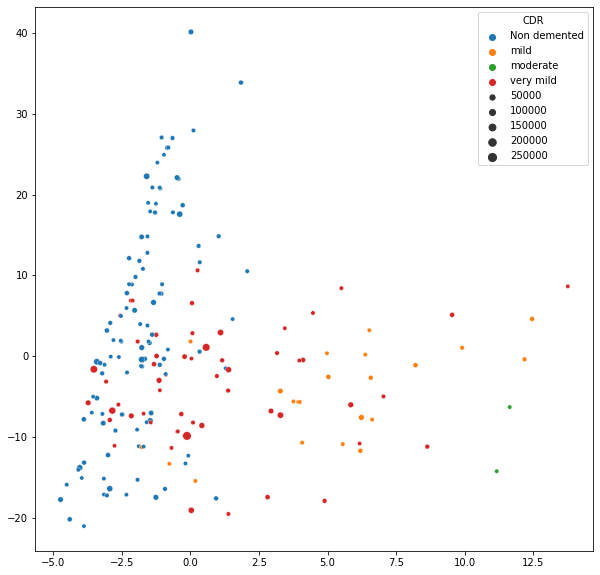

In [ ]:
fig = plt.figure(figsize = (10,10))
sns.scatterplot(x = X_transformed[:,-1], y = X_transformed[:,-2], hue = y_train, size = np.power( X_transformed[:,-3], 2))

## **Base model**

### Logistic Regression

In [ ]:
X_train_scaled.head()

M/F       Age  Educ  SES      MMSE      eTIV      nWBV
183    0  1.096646   4.0  1.0 -0.264786 -0.040117  0.080727
322    0 -0.336257   3.0  2.0  0.800021  0.239216 -0.210732
188    0  0.506627   5.0  1.0  0.800021 -1.357838 -0.065002
243    0  1.770953   3.0  2.0  0.800021 -1.181737 -0.981016
107    1  0.000897   5.0  1.0 -0.264786  2.698558 -0.502191

In [ ]:
lr = LogisticRegression(max_iter = 1000)
param_grid = {'C': [1e-4, 1e-3, 1e-2, 0.1, 0.5, 1, 5,10]}
lr_grid = GridSearchCV(estimator = lr, param_grid = param_grid, cv = 10, scoring = 'accuracy')

lr_grid.fit(X_train_scaled, y_train)

lr_grid.best_score_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


0.7333333333333334

In [ ]:
lr_grid.best_params_

{'C': 0.5}

Logistic regression model with very less regularisation has an accuracy of 73.3%

### Dtree

In [ ]:
y_train.value_counts()

Non demented    108
very mild        56
mild             22
moderate          2
Name: CDR, dtype: int64

In [ ]:
dtree = DecisionTreeClassifier()
param_grid = {'max_depth' : np.arange(1,15),
              'min_samples_leaf': np.arange(1,5),
              'max_features': [3, 4, 5, 6 , 7]}

dtree_grid = GridSearchCV(estimator=dtree, param_grid=param_grid, cv=10)
dtree_grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'max_features': [3, 4, 5, 6, 7],
                         'min_samples_leaf': array([1, 2, 3, 4])})

In [ ]:
dtree_grid.best_params_

{'max_depth': 2, 'max_features': 5, 'min_samples_leaf': 2}

In [ ]:
dtree_grid.best_score_

0.7394736842105263

## **Ensembles**

### Bagging v1

Tuning `n_estimators` and `max_depth` of dtree

In [ ]:
bagging = BaggingClassifier(DecisionTreeClassifier(class_weight = 'balanced'), oob_score = True, warm_start = False, n_jobs = -1)
oobscore_dict = {}

num_estimators_list = [10, 40, 60, 80, 100, 140, 180]
max_depth_list = range(6,15)


for num_estimators, max_depth in product(num_estimators_list, max_depth_list):
  bagging.set_params(n_estimators = num_estimators, base_estimator__max_depth = max_depth)
  bagging.fit(X_train, y_train)
  oobscore_dict[(num_estimators, max_depth)] = bagging.oob_score_

best_n_estimators = sorted(oobscore_dict.items(), key = lambda x: -x[1])[0][0]

In [ ]:
sorted(oobscore_dict.items(), key = lambda x: -x[1])[0]

((40, 14), 0.7446808510638298)

In [ ]:
best_n_estimators

(40, 14)

### Bagging v2
Tuning 
- `max_samples` - The number of samples to draw from X to train each base estimator with replacement
- `max_features` - The number of features to draw from X to train each base estimator without replacement by default

Along with `max_depth` and `n_estimators`.

In [ ]:
bagging = BaggingClassifier(DecisionTreeClassifier(class_weight = 'balanced'), oob_score = True, warm_start = False, n_jobs = -1)
oobscore_dict = {}

num_estimators_list = [10,40, 60, 80, 100, 140, 180]
max_depth_list = [11, 12, 13, 14]
max_samples_list = [0.4, 0.6, 0.8, 1.0]
max_features_list = [0.4, 0.6, 0.8, 1.0]

verbose = True

for num_estimators, max_depth, max_samples, max_features in product(num_estimators_list, max_depth_list, max_samples_list, max_features_list):
  bagging.set_params(n_estimators = num_estimators, max_samples = max_samples, max_features = max_features, base_estimator__max_depth = max_depth)
  bagging.fit(X_train, y_train)
  bag_oob = bagging.oob_score_
  oobscore_dict[(num_estimators, max_depth, max_samples, max_features)] = bag_oob

  if verbose:
    print(f"{(num_estimators, max_depth, max_samples, max_features)} ---> {bag_oob}")

best_n_estimators = sorted(oobscore_dict.items(), key = lambda x: -x[1])[0][0]

(10, 14, 0.6, 1.0) ---> 0.6861702127659575
(10, 14, 0.8, 0.4) ---> 0.5585106382978723
(10, 14, 0.8, 0.6) ---> 0.6702127659574468
(10, 14, 0.8, 0.8) ---> 0.6648936170212766


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:707: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:707: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:707: UserWar

(10, 14, 0.8, 1.0) ---> 0.7021276595744681
(10, 14, 1.0, 0.4) ---> 0.574468085106383
(10, 14, 1.0, 0.6) ---> 0.6861702127659575
(10, 14, 1.0, 0.8) ---> 0.6595744680851063


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:707: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


(10, 14, 1.0, 1.0) ---> 0.6968085106382979
(40, 11, 0.4, 0.4) ---> 0.6914893617021277
(40, 11, 0.4, 0.6) ---> 0.6861702127659575
(40, 11, 0.4, 0.8) ---> 0.7074468085106383
(40, 11, 0.4, 1.0) ---> 0.7127659574468085
(40, 11, 0.6, 0.4) ---> 0.6117021276595744
(40, 11, 0.6, 0.6) ---> 0.6968085106382979
(40, 11, 0.6, 0.8) ---> 0.7021276595744681
(40, 11, 0.6, 1.0) ---> 0.7021276595744681
(40, 11, 0.8, 0.4) ---> 0.5797872340425532
(40, 11, 0.8, 0.6) ---> 0.6914893617021277
(40, 11, 0.8, 0.8) ---> 0.7021276595744681
(40, 11, 0.8, 1.0) ---> 0.723404255319149
(40, 11, 1.0, 0.4) ---> 0.6276595744680851
(40, 11, 1.0, 0.6) ---> 0.6436170212765957
(40, 11, 1.0, 0.8) ---> 0.6702127659574468
(40, 11, 1.0, 1.0) ---> 0.6595744680851063
(40, 12, 0.4, 0.4) ---> 0.6595744680851063
(40, 12, 0.4, 0.6) ---> 0.6914893617021277
(40, 12, 0.4, 0.8) ---> 0.6861702127659575
(40, 12, 0.4, 1.0) ---> 0.7074468085106383
(40, 12, 0.6, 0.4) ---> 0.6595744680851063
(40, 12, 0.6, 0.6) ---> 0.6436170212765957
(40, 12, 0.6

In [ ]:
sorted(oobscore_dict.items(), key = lambda x: -x[1])[0]

((10, 12, 1.0, 1.0), 0.7340425531914894)

### RF

In [ ]:
rf = RandomForestClassifier(class_weight = 'balanced_subsample' ,oob_score = True, warm_start = False, n_jobs = -1)
oobscore_dict = {}

num_estimators_list = [10,40, 60, 80, 100, 140, 180]
max_depth_list = [10, 11, 12, 13, 14, 15]
max_features_list = [0.4, 0.5, 0.6, 0.8, 1.0]

verbose = True

for num_estimators, max_depth, max_features in product(num_estimators_list, max_depth_list, max_features_list):
  rf.set_params(n_estimators = num_estimators, max_depth = max_depth, max_features = max_features)
  rf.fit(X_train, y_train)
  rf_oob = rf.oob_score_
  oobscore_dict[(num_estimators, max_depth, max_features)] = rf_oob

  if verbose:
    print(f"{num_estimators, max_depth, max_features} ---> {rf_oob}")

best_params = sorted(oobscore_dict.items(), key = lambda x: -x[1])[0][0]

(10, 10, 0.4) ---> 0.6382978723404256
(10, 10, 0.5) ---> 0.601063829787234


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


(10, 10, 0.6) ---> 0.6648936170212766
(10, 10, 0.8) ---> 0.6595744680851063


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


(10, 10, 1.0) ---> 0.6702127659574468
(10, 11, 0.4) ---> 0.6542553191489362


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


(10, 11, 0.5) ---> 0.6595744680851063
(10, 11, 0.6) ---> 0.6702127659574468


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


(10, 11, 0.8) ---> 0.6542553191489362
(10, 11, 1.0) ---> 0.7127659574468085


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


(10, 12, 0.4) ---> 0.6648936170212766
(10, 12, 0.5) ---> 0.5957446808510638


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


(10, 12, 0.6) ---> 0.6914893617021277
(10, 12, 0.8) ---> 0.648936170212766


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


(10, 12, 1.0) ---> 0.6968085106382979
(10, 13, 0.4) ---> 0.6595744680851063


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


(10, 13, 0.5) ---> 0.6702127659574468
(10, 13, 0.6) ---> 0.6436170212765957


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


(10, 13, 0.8) ---> 0.675531914893617
(10, 13, 1.0) ---> 0.6914893617021277


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


(10, 14, 0.4) ---> 0.675531914893617
(10, 14, 0.5) ---> 0.6914893617021277


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


(10, 14, 0.6) ---> 0.6968085106382979
(10, 14, 0.8) ---> 0.6276595744680851


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


(10, 14, 1.0) ---> 0.7021276595744681
(10, 15, 0.4) ---> 0.601063829787234


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


(10, 15, 0.5) ---> 0.648936170212766
(10, 15, 0.6) ---> 0.648936170212766


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


(10, 15, 0.8) ---> 0.6223404255319149
(10, 15, 1.0) ---> 0.6808510638297872
(40, 10, 0.4) ---> 0.6808510638297872
(40, 10, 0.5) ---> 0.7074468085106383
(40, 10, 0.6) ---> 0.7021276595744681
(40, 10, 0.8) ---> 0.6648936170212766
(40, 10, 1.0) ---> 0.6861702127659575
(40, 11, 0.4) ---> 0.6542553191489362
(40, 11, 0.5) ---> 0.6542553191489362
(40, 11, 0.6) ---> 0.6276595744680851
(40, 11, 0.8) ---> 0.6595744680851063
(40, 11, 1.0) ---> 0.723404255319149
(40, 12, 0.4) ---> 0.675531914893617
(40, 12, 0.5) ---> 0.675531914893617
(40, 12, 0.6) ---> 0.6861702127659575
(40, 12, 0.8) ---> 0.7074468085106383
(40, 12, 1.0) ---> 0.7021276595744681
(40, 13, 0.4) ---> 0.6914893617021277
(40, 13, 0.5) ---> 0.6808510638297872
(40, 13, 0.6) ---> 0.6968085106382979
(40, 13, 0.8) ---> 0.6861702127659575
(40, 13, 1.0) ---> 0.7074468085106383
(40, 14, 0.4) ---> 0.7021276595744681
(40, 14, 0.5) ---> 0.6861702127659575
(40, 14, 0.6) ---> 0.6968085106382979
(40, 14, 0.8) ---> 0.6914893617021277
(40, 14, 1.0) -

In [ ]:
sorted(oobscore_dict.items(), key = lambda x: -x[1])[0]

### Boosting

#### AdaBoost

In [ ]:
boosting = AdaBoostClassifier(base_estimator = DecisionTreeClassifier())
param_grid = {'n_estimators': [10,40, 60, 80, 100, 140, 180],
              'learning_rate': np.concatenate( (np.arange(0.01,0.1,0.02), np.array([0.001, 0.005])) ),
              'base_estimator__max_depth': [1, 2, 3]}
boost_grid = GridSearchCV(estimator = boosting, param_grid = param_grid, scoring = 'f1_micro' ,cv = 10, verbose = 1)
boost_grid.fit(X_train,y_train)

Fitting 10 folds for each of 147 candidates, totalling 1470 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


GridSearchCV(cv=10,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             param_grid={'base_estimator__max_depth': [1, 2, 3],
                         'learning_rate': array([0.01 , 0.03 , 0.05 , 0.07 , 0.09 , 0.001, 0.005]),
                         'n_estimators': [10, 40, 60, 80, 100, 140, 180]},
             scoring='f1_micro', verbose=1)

In [ ]:
boost_grid.best_params_

{'base_estimator__max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 10}

In [ ]:
boost_grid.best_score_

0.7347953216374268

In [ ]:
import pickle

best_model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 2), learning_rate = 0.01, n_estimators = 10)
best_model.fit(X_train, y_train)

pickle.dump(best_model, open('/content/drive/MyDrive/DS2- Project/OASIS 1/best_model_boost.pkl', 'wb'))

In [ ]:
print(f"The accuracy on train is {accuracy_score(y_train, best_model.predict(X_train)):.2f}")
print(f"The accuracy on test is {accuracy_score(y_test, best_model.predict(X_test)):.2f}")

The accuracy on train is 0.73
The accuracy on test is 0.72


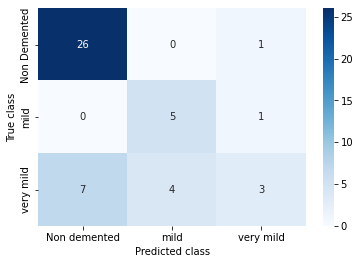

In [ ]:
sns.heatmap(pd.DataFrame(data = confusion_matrix(y_test, best_model.predict(X_test)), columns = np.unique(best_model.predict(X_test)), index =  ['Non Demented', 'mild', 'very mild']),cmap='Blues', annot =True, fmt='')
plt.xlabel("Predicted class")
plt.ylabel('True class')
plt.show()

#### GradientBoosting

In [ ]:
Gboosting = GradientBoostingClassifier()
param_grid = {'n_estimators': [10,40, 60, 80, 100, 140, 180],
              'learning_rate': np.concatenate( (np.arange(0.01,0.1,0.02), np.array([0.001, 0.005])) ),
              'max_depth': [1, 2, 3]}
Gboost_grid = GridSearchCV(estimator = Gboosting, param_grid = param_grid, scoring = 'f1_micro' ,cv = 5, verbose = 1)
Gboost_grid.fit(X_train,y_train)

Fitting 10 folds for each of 147 candidates, totalling 1470 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


GridSearchCV(cv=10, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': array([0.01 , 0.03 , 0.05 , 0.07 , 0.09 , 0.001, 0.005]),
                         'max_depth': [1, 2, 3],
                         'n_estimators': [10, 40, 60, 80, 100, 140, 180]},
             scoring='f1_micro', verbose=1)

In [ ]:
Gboost_grid.best_params_

{'learning_rate': 0.08999999999999998, 'max_depth': 1, 'n_estimators': 10}

In [ ]:
Gboost_grid.best_score_

0.7453216374269005

#### XGBOOST

In [ ]:
X_train_scaled.head()

M/F       Age  Educ  SES      MMSE      eTIV      nWBV
8      1  0.153224   5.0  2.0  0.810803  1.033018 -1.241080
298    0  0.649879   1.0  5.0 -0.016128 -0.524991  0.092074
322    0 -0.343432   3.0  2.0  0.810803  0.238739 -0.161860
125    1 -0.674536   2.0  4.0  0.535159  0.574780  1.128971
66     0 -1.916175   5.0  1.0  0.810803 -0.048424  1.277099

In [ ]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.2],
              'max_depth': [1, 3, 4, 8, 10, 12, 13],
              'gamma': [0, 0.25, 0.5, 1, 3], # default 0
              'reg_lamba': [0, 0.5, 10, 20]} # default 1

xgb_grid = GridSearchCV(estimator = xgb_clf, param_grid = param_grid , scoring = 'f1_micro' ,cv = 10, verbose = 1)

xgb_grid.fit(X_train_scaled, y_train)
xgb_grid.best_score_

Fitting 10 folds for each of 560 candidates, totalling 5600 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


0.7347953216374268

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, xgb_grid.predict(X_test_scaled), normalize = 'true')

cm

array([[0.81481481, 0.03703704, 0.14814815],
       [0.16666667, 0.33333333, 0.5       ],
       [0.35714286, 0.21428571, 0.42857143]])

In [ ]:
y_test.value_counts()

Non demented    27
very mild       14
mild             6
moderate         0
Name: CDR, dtype: int64

In [ ]:
xgb_grid.score(X_train_scaled, y_train)

1.0

In [ ]:
xgb_grid.best_params_

{'gamma': 0.25, 'learning_rate': 0.05, 'max_depth': 8, 'reg_lamba': 0}

# **Dealing with class imbalance**

## Oversampling - 
SMOTE does not work properly with minority class having only 2 observations.

In [ ]:
X_train.head()

M/F  Age  Educ  SES  MMSE  eTIV   nWBV
164    0   87   2.0  4.0  21.0  1250  0.653
197    0   71   4.0  3.0  30.0  1503  0.792
302    0   80   1.0  4.0  27.0  1654  0.678
19     0   80   3.0  3.0  23.0  1794  0.765
132    1   70   4.0  1.0  27.0  1581  0.695

In [ ]:
y_train.value_counts()

Non demented    108
very mild        56
mild             22
moderate          2
Name: CDR, dtype: int64

Among different oversampling techniques, we can safely rule out random sampling because some of the classes have very less number of observations.

In [ ]:
sm = SMOTENC(categorical_features = [0], sampling_strategy={'Non demented':108, 'very mild': 108, 'mild': 108, 'moderate': 2})
X_train_os, y_train_os = sm.fit_resample(X_train, y_train)

In [ ]:
y_train_os.value_counts()

Non demented    108
mild            108
very mild       108
moderate          2
Name: CDR, dtype: int64

##### Dtree

In [ ]:
dtree = DecisionTreeClassifier()
param_grid = {'max_depth' : np.arange(1,15),
              'min_samples_leaf': np.arange(1,5),
              'max_features': [3, 4, 5, 6 , 7]}

dtree_grid = GridSearchCV(estimator=dtree, param_grid=param_grid, cv=10, n_jobs = -1)
dtree_grid.fit(X_train_os, y_train_os)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'max_features': [3, 4, 5, 6, 7],
                         'min_samples_leaf': array([1, 2, 3, 4])})

In [ ]:
dtree_grid.best_params_

{'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 2}

In [ ]:
dtree_grid.best_score_

0.7976325757575757

In [ ]:
dtree_grid.score(X_test, y_test)

0.6382978723404256

##### **Ensembles**

###### Bagging v1

Tuning `n_estimators` and `max_depth` of dtree

In [ ]:
bagging = BaggingClassifier(DecisionTreeClassifier(class_weight = 'balanced'), oob_score = True, warm_start = False, n_jobs = -1)
oobscore_dict = {}

num_estimators_list = range(40,200,10)
max_depth_list = range(6,15)


for num_estimators, max_depth in product(num_estimators_list, max_depth_list):
  bagging.set_params(n_estimators = num_estimators, base_estimator__max_depth = max_depth)
  bagging.fit(X_train_os, y_train_os)
  oobscore_dict[(num_estimators, max_depth)] = bagging.oob_score_

best_n_estimators = sorted(oobscore_dict.items(), key = lambda x: -x[1])[0][0]

In [ ]:
sorted(oobscore_dict.items(), key = lambda x: -x[1])[0]

((120, 14), 0.8958333333333334)

In [ ]:
best_n_estimators

(120, 14)

###### Bagging v2
Tuning 
- `max_samples` - The number of samples to draw from X to train each base estimator with replacement
- `max_features` - The number of features to draw from X to train each base estimator without replacement by default

Along with `max_depth` and `n_estimators`.

In [ ]:
bagging = BaggingClassifier(DecisionTreeClassifier(), oob_score = True, warm_start = False, n_jobs = -1)
oobscore_dict = {}

num_estimators_list = range(40,200,10)
max_depth_list = [11, 12, 13, 14]
max_samples_list = [0.4, 0.6, 0.8, 1.0]
max_features_list = [0.4, 0.6, 0.8, 1.0]

verbose = True

for num_estimators, max_depth, max_samples, max_features in product(num_estimators_list, max_depth_list, max_samples_list, max_features_list):
  bagging.set_params(n_estimators = num_estimators, max_samples = max_samples, max_features = max_features, base_estimator__max_depth = max_depth)
  bagging.fit(X_train, y_train)
  bag_oob = bagging.oob_score_
  oobscore_dict[(num_estimators, max_depth, max_samples, max_features)] = bag_oob

  if verbose:
    print(f"{(num_estimators, max_depth, max_samples, max_features)} ---> {bag_oob}")

best_n_estimators = sorted(oobscore_dict.items(), key = lambda x: -x[1])[0][0]

(40, 11, 0.4, 0.4) ---> 0.6329787234042553
(40, 11, 0.4, 0.6) ---> 0.6702127659574468
(40, 11, 0.4, 0.8) ---> 0.7021276595744681
(40, 11, 0.4, 1.0) ---> 0.723404255319149
(40, 11, 0.6, 0.4) ---> 0.601063829787234
(40, 11, 0.6, 0.6) ---> 0.6914893617021277
(40, 11, 0.6, 0.8) ---> 0.6968085106382979
(40, 11, 0.6, 1.0) ---> 0.7287234042553191
(40, 11, 0.8, 0.4) ---> 0.5957446808510638
(40, 11, 0.8, 0.6) ---> 0.6914893617021277
(40, 11, 0.8, 0.8) ---> 0.6808510638297872
(40, 11, 0.8, 1.0) ---> 0.6808510638297872
(40, 11, 1.0, 0.4) ---> 0.6595744680851063
(40, 11, 1.0, 0.6) ---> 0.6595744680851063
(40, 11, 1.0, 0.8) ---> 0.7021276595744681
(40, 11, 1.0, 1.0) ---> 0.6808510638297872
(40, 12, 0.4, 0.4) ---> 0.648936170212766
(40, 12, 0.4, 0.6) ---> 0.7074468085106383
(40, 12, 0.4, 0.8) ---> 0.7393617021276596
(40, 12, 0.4, 1.0) ---> 0.7287234042553191
(40, 12, 0.6, 0.4) ---> 0.6329787234042553
(40, 12, 0.6, 0.6) ---> 0.7287234042553191
(40, 12, 0.6, 0.8) ---> 0.648936170212766
(40, 12, 0.6, 1

In [ ]:
sorted(oobscore_dict.items(), key = lambda x: -x[1])[0]

((160, 13, 0.4, 1.0), 0.7553191489361702)

###### RF

In [ ]:
rf = RandomForestClassifier(oob_score = True, warm_start = False, n_jobs = -1)
oobscore_dict = {}

num_estimators_list = range(40,200,10)
max_depth_list = [10, 11, 12, 13, 14, 15]
max_features_list = [0.4, 0.5, 0.6, 0.8, 1.0]

verbose = True

for num_estimators, max_depth, max_features in product(num_estimators_list, max_depth_list, max_features_list):
  rf.set_params(n_estimators = num_estimators, max_depth = max_depth, max_features = max_features)
  rf.fit(X_train, y_train)
  rf_oob = rf.oob_score_
  oobscore_dict[(num_estimators, max_depth, max_features)] = rf_oob

  if verbose:
    print(f"{num_estimators, max_depth, max_features} ---> {rf_oob}")

best_params = sorted(oobscore_dict.items(), key = lambda x: -x[1])[0][0]

(40, 10, 0.4) ---> 0.7127659574468085
(40, 10, 0.5) ---> 0.7127659574468085
(40, 10, 0.6) ---> 0.7446808510638298
(40, 10, 0.8) ---> 0.7180851063829787
(40, 10, 1.0) ---> 0.7074468085106383
(40, 11, 0.4) ---> 0.7074468085106383
(40, 11, 0.5) ---> 0.7127659574468085
(40, 11, 0.6) ---> 0.6808510638297872
(40, 11, 0.8) ---> 0.7287234042553191
(40, 11, 1.0) ---> 0.7021276595744681
(40, 12, 0.4) ---> 0.7021276595744681
(40, 12, 0.5) ---> 0.6702127659574468
(40, 12, 0.6) ---> 0.6914893617021277
(40, 12, 0.8) ---> 0.7127659574468085
(40, 12, 1.0) ---> 0.7021276595744681
(40, 13, 0.4) ---> 0.6861702127659575
(40, 13, 0.5) ---> 0.7074468085106383
(40, 13, 0.6) ---> 0.7127659574468085
(40, 13, 0.8) ---> 0.7127659574468085
(40, 13, 1.0) ---> 0.6808510638297872
(40, 14, 0.4) ---> 0.6968085106382979
(40, 14, 0.5) ---> 0.6968085106382979
(40, 14, 0.6) ---> 0.7180851063829787
(40, 14, 0.8) ---> 0.7127659574468085
(40, 14, 1.0) ---> 0.723404255319149
(40, 15, 0.4) ---> 0.6648936170212766
(40, 15, 0.5)

In [ ]:
sorted(oobscore_dict.items(), key = lambda x: -x[1])[0]

((50, 15, 0.6), 0.7659574468085106)

##### Boosting

###### AdaBoost

In [ ]:
boosting = AdaBoostClassifier(base_estimator = DecisionTreeClassifier())
param_grid = {'n_estimators': range(10, 150, 10),
              'learning_rate': np.concatenate( (np.arange(0.01,0.1,0.02), np.array([0.001, 0.005])) ),
              'base_estimator__max_depth': [1, 2, 3]}
boost_grid = GridSearchCV(estimator = boosting, param_grid = param_grid, cv = 10, verbose = 1, n_jobs = -1)
boost_grid.fit(X_train_os,y_train_os)


Fitting 10 folds for each of 294 candidates, totalling 2940 fits


GridSearchCV(cv=10,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [1, 2, 3],
                         'learning_rate': array([0.01 , 0.03 , 0.05 , 0.07 , 0.09 , 0.001, 0.005]),
                         'n_estimators': range(10, 150, 10)},
             verbose=1)

In [ ]:
boost_grid.best_params_

{'base_estimator__max_depth': 3, 'learning_rate': 0.03, 'n_estimators': 30}

In [ ]:
boost_grid.best_score_

0.8403276955602536

In [ ]:
boost_grid.score(X_test, y_test)

0.723404255319149

###### GradientBoosting

In [ ]:
Gboosting = GradientBoostingClassifier()
param_grid = {'n_estimators': range(10, 150, 10),
              'learning_rate': np.concatenate( (np.arange(0.01,0.1,0.02), np.array([0.001, 0.005])) ),
              'max_depth': [1, 2, 3]}
Gboost_grid = GridSearchCV(estimator = Gboosting, param_grid = param_grid, cv = 10, verbose = 1)
Gboost_grid.fit(X_train,y_train)

Fitting 10 folds for each of 294 candidates, totalling 2940 fits


GridSearchCV(cv=10, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': array([0.01 , 0.03 , 0.05 , 0.07 , 0.09 , 0.001, 0.005]),
                         'max_depth': [1, 2, 3],
                         'n_estimators': range(10, 150, 10)},
             verbose=1)

In [ ]:
Gboost_grid.best_params_

{'learning_rate': 0.03, 'max_depth': 1, 'n_estimators': 50}

In [ ]:
Gboost_grid.best_score_

0.7453216374269006

###### XGBOOST
NOTE: tune min_child_weight

In [ ]:
X_train_scaled.head()

M/F       Age  Educ  SES      MMSE      eTIV      nWBV
298    0  0.661187   1.0  5.0 -0.043575 -0.520115  0.051770
149    0  0.984262   2.0  2.0 -0.043575 -0.465893 -0.464835
108    0 -1.600338   5.0  1.0  0.775635 -0.568313  0.713025
338    0  0.095805   3.0  3.0  0.502565 -1.381654  0.217084
272    0  1.468874   3.0  2.0  0.229495  0.166706  0.237748

In [ ]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.2],
              'max_depth': [1, 3, 4, 8, 10, 12, 13],
              'gamma': [0, 0.25, 0.5, 1, 3], # default 0
              'reg_lamba': [0, 0.5, 10, 20]} # default 1

xgb_grid = GridSearchCV(estimator = xgb_clf, param_grid = param_grid , cv = 10, verbose = 1)

xgb_grid.fit(X_train_scaled, y_train)
xgb_grid.best_score_

Fitting 10 folds for each of 560 candidates, totalling 5600 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


0.7336257309941521

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, xgb_grid.predict(X_test_scaled), normalize = 'true')

cm

array([[0.81481481, 0.03703704, 0.14814815],
       [0.16666667, 0.33333333, 0.5       ],
       [0.35714286, 0.21428571, 0.42857143]])

In [ ]:
y_test.value_counts()

Non demented    27
very mild       14
mild             6
moderate         0
Name: CDR, dtype: int64

In [ ]:
xgb_grid.score(X_train_scaled, y_train)

1.0

In [ ]:
xgb_grid.best_params_

{'gamma': 0.25, 'learning_rate': 0.05, 'max_depth': 8, 'reg_lamba': 0}

# **Ordinal Regression (Classification)**

Custom implementation

#### Preparing data

In [ ]:
X_train.head()

M/F  Age  Educ  SES  MMSE  eTIV   nWBV
272    0   90   3.0  2.0  28.0  1495  0.761
23     0   58   5.0  1.0  30.0  1235  0.820
352    0   77   2.0  4.0  22.0  1350  0.736
286    0   72   4.0  2.0  22.0  1493  0.690
32     0   84   3.0  2.0  28.0  1402  0.695

In [ ]:
y_train_ord = y_train.map({'Non demented': 0, 'mild': 1, 'moderate': 2, 'very mild': 0.5}).astype('float')
y_test_ord = y_test.map({'Non demented': 0, 'mild': 1, 'moderate': 2, 'very mild': 0.5}).astype('float')
y_train_ord.head()

272    0.0
23     0.0
352    1.0
286    1.0
32     1.0
Name: CDR, dtype: float64

In [ ]:
y_train_ord.value_counts()

0.0    108
0.5     56
1.0     22
2.0      2
Name: CDR, dtype: int64

 - 0 : Non demented
 - 0.5 : very mild
 - 1 : mild
 - 2 : moderate


model_0 : target>0<br/>
model_05 : target>0.5<br/>
model_1 : target>1<br/>


prob of 0 = `1 - prob of model_0`<br/>
prob of 0.5 = `prob of model_0 - prob of model_05`<br/>
prob of 1 = `prob of model_05 - prob of model_1`<br/>
prob of 2 = `prob of model_1`

In [ ]:
y_train_0 = np.where(y_train_ord>0, 1, 0)
y_train_05 = np.where(y_train_ord>0.5, 1, 0)
y_train_1 = np.where(y_train_ord>1, 1, 0)


y_test_0 = np.where(y_test_ord>0, 1, 0)
y_test_05 = np.where(y_test_ord>0.5, 1, 0)
y_test_1 = np.where(y_test_ord>1, 1, 0)

In [ ]:
X_train.head()

M/F  Age  Educ  SES  MMSE  eTIV   nWBV
272    0   90   3.0  2.0  28.0  1495  0.761
23     0   58   5.0  1.0  30.0  1235  0.820
352    0   77   2.0  4.0  22.0  1350  0.736
286    0   72   4.0  2.0  22.0  1493  0.690
32     0   84   3.0  2.0  28.0  1402  0.695

In [ ]:
sm = SMOTENC(categorical_features = [0], n_jobs = -1)
X_train0_OS, y_train_0_OS = sm.fit_resample(X_train, y_train_0)
X_train05_OS, y_train_05_OS = sm.fit_resample(X_train, y_train_05)

### model_0 ---> target>0

In [ ]:
np.unique(y_train_0, return_counts = True)

(array([0, 1]), array([108,  80]))

##### Bagging v2
Tuning 
- `max_samples` - The number of samples to draw from X to train each base estimator with replacement
- `max_features` - The number of features to draw from X to train each base estimator without replacement by default

Along with `max_depth` and `n_estimators`.

In [ ]:
bagging = BaggingClassifier(DecisionTreeClassifier(), oob_score = False, warm_start = True, n_jobs = -1)

params = dict(n_estimators = [10,40, 60, 80, 100, 140, 180],
              base_estimator__max_depth = [11, 12, 13, 14],
              max_samples = [0.4, 0.6, 0.8, 1.0],
              max_features = [0.4, 0.6, 0.8, 1.0],
              base_estimator__class_weight = [{0:1,1:1}, {0:1, 1:1.4}])

bagging_grid = GridSearchCV(bagging, params, scoring = 'roc_auc', verbose = 4)
bagging_grid.fit(X_train, y_train_0)

"""
oobscore_dict = {}

num_estimators_list = range(40,200,10)
max_depth_list = [11, 12, 13, 14]
max_samples_list = [0.4, 0.6, 0.8, 1.0]
max_features_list = [0.4, 0.6, 0.8, 1.0]

verbose = True

for num_estimators, max_depth, max_samples, max_features in product(num_estimators_list, max_depth_list, max_samples_list, max_features_list):
  bagging.set_params(n_estimators = num_estimators, max_samples = max_samples, max_features = max_features, base_estimator__max_depth = max_depth)
  bagging.fit(X_train, y_train_0)
  bag_oob = bagging.oob_score_
  oobscore_dict[(num_estimators, max_depth, max_samples, max_features)] = bag_oob

  if verbose:
    print(f"{(num_estimators, max_depth, max_samples, max_features)} ---> {bag_oob}")

best_n_estimators = sorted(oobscore_dict.items(), key = lambda x: -x[1])[0][0]
"""

# print(f"Val f1 score {bagging_grid.score(X_test, y_test_0)}")
print(f"Val roc auc score {bagging_grid.score(X_test, y_test_0)}")
bagging_grid.score(X_train, y_train_0)

Fitting 5 folds for each of 896 candidates, totalling 4480 fits
[CV 1/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=11, max_features=0.4, max_samples=0.4, n_estimators=10;, score=0.837 total time=   1.8s
[CV 2/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=11, max_features=0.4, max_samples=0.4, n_estimators=10;, score=0.766 total time=   0.1s
[CV 3/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=11, max_features=0.4, max_samples=0.4, n_estimators=10;, score=0.695 total time=   0.1s
[CV 4/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=11, max_features=0.4, max_samples=0.4, n_estimators=10;, score=0.927 total time=   0.1s
[CV 5/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=11, max_features=0.4, max_samples=0.4, n_estimators=10;, score=0.906 total time=   0.1s
[CV 1/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=11, 

0.9880208333333333

In [ ]:
bagging_grid.best_params_

{'base_estimator__class_weight': {0: 1, 1: 1.4},
 'base_estimator__max_depth': 13,
 'max_features': 1.0,
 'max_samples': 0.4,
 'n_estimators': 40}

In [ ]:
best_bag= BaggingClassifier(DecisionTreeClassifier(max_depth = 13, class_weight = {0: 1, 1: 1.4}), n_estimators = 40, max_samples = 0.4, max_features = 1.0, warm_start = False, n_jobs = -1)

best_bag.fit(X_train, y_train_0)

print(f"f1 val score : {f1_score(y_test_0, best_bag.predict(X_test))} ")
print(f"roc auc val score : {roc_auc_score(y_test_0, best_bag.predict_proba(X_test)[:,1])}")

f1 val score : 0.7777777777777777 
roc auc val score : 0.9083333333333333


##### RF

In [ ]:
rf = RandomForestClassifier(oob_score = True, warm_start = False, n_jobs = -1, class_weight = 'balanced_subsample')
oobscore_dict = {}

num_estimators_list = [40, 60, 80, 100, 140, 180]
max_depth_list = [10, 11, 12, 13, 14, 15]
max_features_list = [0.4, 0.5, 0.6, 0.8, 1.0]

verbose = True

for num_estimators, max_depth, max_features in product(num_estimators_list, max_depth_list, max_features_list):
  rf.set_params(n_estimators = num_estimators, max_depth = max_depth, max_features = max_features)
  rf.fit(X_train, y_train_0)
  rf_oob = rf.oob_score_
  oobscore_dict[(num_estimators, max_depth, max_features)] = rf_oob

  if verbose:
    print(f"{num_estimators, max_depth, max_features} ---> {rf_oob}")

best_params = sorted(oobscore_dict.items(), key = lambda x: -x[1])[0][0]

(40, 10, 0.4) ---> 0.7925531914893617
(40, 10, 0.5) ---> 0.8138297872340425
(40, 10, 0.6) ---> 0.8031914893617021
(40, 10, 0.8) ---> 0.7872340425531915
(40, 10, 1.0) ---> 0.7978723404255319
(40, 11, 0.4) ---> 0.8138297872340425
(40, 11, 0.5) ---> 0.7978723404255319
(40, 11, 0.6) ---> 0.8031914893617021
(40, 11, 0.8) ---> 0.8085106382978723
(40, 11, 1.0) ---> 0.7925531914893617
(40, 12, 0.4) ---> 0.7872340425531915
(40, 12, 0.5) ---> 0.7819148936170213
(40, 12, 0.6) ---> 0.8138297872340425
(40, 12, 0.8) ---> 0.7978723404255319
(40, 12, 1.0) ---> 0.7925531914893617
(40, 13, 0.4) ---> 0.7553191489361702
(40, 13, 0.5) ---> 0.8085106382978723
(40, 13, 0.6) ---> 0.8138297872340425
(40, 13, 0.8) ---> 0.8031914893617021
(40, 13, 1.0) ---> 0.8085106382978723
(40, 14, 0.4) ---> 0.8404255319148937
(40, 14, 0.5) ---> 0.8085106382978723
(40, 14, 0.6) ---> 0.7872340425531915
(40, 14, 0.8) ---> 0.7872340425531915
(40, 14, 1.0) ---> 0.7925531914893617
(40, 15, 0.4) ---> 0.7659574468085106
(40, 15, 0.5

In [ ]:
best_params

(100, 10, 0.4)

In [ ]:
sorted(oobscore_dict.items(), key = lambda x: -x[1])[0]

((100, 10, 0.4), 0.851063829787234)

In [ ]:
best_rf = RandomForestClassifier(n_estimators = 100,max_depth=10, max_features = 0.4, oob_score = True, warm_start = False, n_jobs = -1, class_weight = 'balanced_subsample')
best_rf.fit(X_train, y_train_0)

print(f"f1 val score : {f1_score(y_test_0, best_rf.predict(X_test))} ")
print(f"roc auc val score : {roc_auc_score(y_test_0, best_rf.predict_proba(X_test)[:,1])}")

f1 val score : 0.7368421052631577 
roc auc val score : 0.912962962962963


##### Balanced Random forest

In [ ]:
Balanced_rf = BalancedRandomForestClassifier(oob_score = True, warm_start = False, n_jobs = -1, class_weight='balanced_subsample' )
oobscore_dict = {}

num_estimators_list = [40, 60, 80, 100, 140, 180]
max_depth_list = [10, 11, 12, 13, 14, 15]
max_features_list = [0.4, 0.5, 0.6, 0.8, 1.0]

verbose = True

for num_estimators, max_depth, max_features in product(num_estimators_list, max_depth_list, max_features_list):
  Balanced_rf.set_params(n_estimators = num_estimators, max_depth = max_depth, max_features = max_features)
  Balanced_rf.fit(X_train, y_train_0)
  rf_oob = Balanced_rf.oob_score_
  oobscore_dict[(num_estimators, max_depth, max_features)] = rf_oob

  if verbose:
    print(f"{num_estimators, max_depth, max_features} ---> {rf_oob}")

best_params = sorted(oobscore_dict.items(), key = lambda x: -x[1])[0][0]

(40, 10, 0.4) ---> 0.7872340425531915
(40, 10, 0.5) ---> 0.824468085106383
(40, 10, 0.6) ---> 0.8138297872340425
(40, 10, 0.8) ---> 0.7925531914893617
(40, 10, 1.0) ---> 0.7978723404255319
(40, 11, 0.4) ---> 0.7978723404255319
(40, 11, 0.5) ---> 0.8085106382978723
(40, 11, 0.6) ---> 0.8191489361702128
(40, 11, 0.8) ---> 0.7872340425531915
(40, 11, 1.0) ---> 0.8138297872340425
(40, 12, 0.4) ---> 0.7925531914893617
(40, 12, 0.5) ---> 0.7925531914893617
(40, 12, 0.6) ---> 0.7606382978723404
(40, 12, 0.8) ---> 0.7925531914893617
(40, 12, 1.0) ---> 0.7872340425531915
(40, 13, 0.4) ---> 0.8085106382978723
(40, 13, 0.5) ---> 0.7925531914893617
(40, 13, 0.6) ---> 0.7925531914893617
(40, 13, 0.8) ---> 0.7925531914893617
(40, 13, 1.0) ---> 0.7712765957446809
(40, 14, 0.4) ---> 0.8191489361702128
(40, 14, 0.5) ---> 0.8297872340425532
(40, 14, 0.6) ---> 0.7978723404255319
(40, 14, 0.8) ---> 0.7872340425531915
(40, 14, 1.0) ---> 0.8031914893617021
(40, 15, 0.4) ---> 0.7978723404255319
(40, 15, 0.5)

In [ ]:
sorted(oobscore_dict.items(), key = lambda x: -x[1])[0]

((140, 11, 0.8), 0.8404255319148937)

In [ ]:
best_bal_rf = BalancedRandomForestClassifier(n_estimators = 140,max_depth=11, max_features = 0.8, oob_score = True, warm_start = False, n_jobs = -1, class_weight = 'balanced_subsample')
best_bal_rf.fit(X_train, y_train_0)

print(f"f1 val score : {f1_score(y_test_0, best_bal_rf.predict(X_test))} ")
print(f"roc auc val score : {roc_auc_score(y_test_0, best_bal_rf.predict_proba(X_test)[:,1])}")

f1 val score : 0.8095238095238095 
roc auc val score : 0.9185185185185185


##### AdaBoost

In [ ]:
boosting = AdaBoostClassifier(base_estimator = DecisionTreeClassifier())
param_grid = {'n_estimators': [20, 40, 80, 100, 140, 180],
              'learning_rate': np.concatenate( (np.arange(0.01,0.1,0.02), np.array([0.001, 0.005])) ),
              'base_estimator__max_depth': [1, 2, 3],
              'base_estimator__class_weight' : [{0:1,1:1}, {0:1, 1:1.4}]}
boost_grid = GridSearchCV(estimator = boosting, param_grid = param_grid, cv = 5, scoring= 'roc_auc', verbose = 4)
boost_grid.fit(X_train, y_train_0)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
[CV 1/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=1, learning_rate=0.01, n_estimators=20;, score=0.844 total time=   0.2s
[CV 2/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=1, learning_rate=0.01, n_estimators=20;, score=0.817 total time=   0.2s
[CV 3/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=1, learning_rate=0.01, n_estimators=20;, score=0.761 total time=   0.2s
[CV 4/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=1, learning_rate=0.01, n_estimators=20;, score=0.756 total time=   0.1s
[CV 5/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=1, learning_rate=0.01, n_estimators=20;, score=0.866 total time=   0.1s
[CV 1/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=1, learning_rate=0.01, n_estimators=40;, score=0.930 total time=   0.2s
[CV 2/5] END

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             param_grid={'base_estimator__class_weight': [{0: 1, 1: 1},
                                                          {0: 1, 1: 1.4}],
                         'base_estimator__max_depth': [1, 2, 3],
                         'learning_rate': array([0.01 , 0.03 , 0.05 , 0.07 , 0.09 , 0.001, 0.005]),
                         'n_estimators': [20, 40, 80, 100, 140, 180]},
             scoring='roc_auc', verbose=4)

In [ ]:
boost_grid.best_params_

{'base_estimator__class_weight': {0: 1, 1: 1.4},
 'base_estimator__max_depth': 3,
 'learning_rate': 0.03,
 'n_estimators': 100}

In [ ]:
boost_grid.best_score_

0.9123647186147187

In [ ]:
best_boost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3, class_weight = {0:1, 1:1.4}), learning_rate =0.03 , n_estimators = 100)
best_boost.fit(X_train, y_train_0)
print(f"f1 val score: {f1_score(y_test_0,best_boost.predict(X_test) )}")
print(f"roc auc val score : {roc_auc_score(y_test_0, best_boost.predict_proba(X_test)[:,1])}")

f1 val score: 0.8000000000000002
roc auc val score : 0.9055555555555556


### model_05 ---> target>0.5

In [ ]:
np.unique(y_train_05, return_counts = True)

(array([0, 1]), array([164,  24]))

##### RF

In [ ]:
rf = RandomForestClassifier(oob_score = True, warm_start = False, n_jobs = -1, class_weight = 'balanced_subsample')
oobscore_dict = {}

num_estimators_list = [20, 40, 60, 80, 100, 140, 180]
max_depth_list = [10, 11, 12, 13, 14, 15]
max_features_list = [0.4, 0.5, 0.6, 0.8, 1.0]

verbose = True

for num_estimators, max_depth, max_features in product(num_estimators_list, max_depth_list, max_features_list):
  rf.set_params(n_estimators = num_estimators, max_depth = max_depth, max_features = max_features)
  rf.fit(X_train, y_train_05)
  rf_oob = rf.oob_score_
  oobscore_dict[(num_estimators, max_depth, max_features)] = rf_oob

  if verbose:
    print(f"{num_estimators, max_depth, max_features} ---> {rf_oob}")

best_params = sorted(oobscore_dict.items(), key = lambda x: -x[1])[0][0]

(20, 10, 0.4) ---> 0.8723404255319149
(20, 10, 0.5) ---> 0.8936170212765957
(20, 10, 0.6) ---> 0.8670212765957447
(20, 10, 0.8) ---> 0.8723404255319149
(20, 10, 1.0) ---> 0.8882978723404256
(20, 11, 0.4) ---> 0.8723404255319149
(20, 11, 0.5) ---> 0.8936170212765957
(20, 11, 0.6) ---> 0.8829787234042553
(20, 11, 0.8) ---> 0.8936170212765957
(20, 11, 1.0) ---> 0.9148936170212766
(20, 12, 0.4) ---> 0.9095744680851063
(20, 12, 0.5) ---> 0.8936170212765957
(20, 12, 0.6) ---> 0.8882978723404256
(20, 12, 0.8) ---> 0.8776595744680851
(20, 12, 1.0) ---> 0.8936170212765957
(20, 13, 0.4) ---> 0.8936170212765957
(20, 13, 0.5) ---> 0.9095744680851063
(20, 13, 0.6) ---> 0.9042553191489362
(20, 13, 0.8) ---> 0.8882978723404256
(20, 13, 1.0) ---> 0.9095744680851063
(20, 14, 0.4) ---> 0.8936170212765957
(20, 14, 0.5) ---> 0.898936170212766
(20, 14, 0.6) ---> 0.9042553191489362
(20, 14, 0.8) ---> 0.8723404255319149
(20, 14, 1.0) ---> 0.8936170212765957
(20, 15, 0.4) ---> 0.8829787234042553
(20, 15, 0.5)

In [ ]:
best_params

(40, 14, 0.8)

In [ ]:
sorted(oobscore_dict.items(), key = lambda x: -x[1])[0]

((40, 14, 0.8), 0.9308510638297872)

In [ ]:
best_rf = RandomForestClassifier(n_estimators = 40,max_depth=14, max_features = 0.8, oob_score = True, warm_start = False, n_jobs = -1, class_weight = 'balanced_subsample')
best_rf.fit(X_train, y_train_05)

print(f"f1 val score : {f1_score(y_test_05, best_rf.predict(X_test))} ")
print(f"roc auc val score : {roc_auc_score(y_test_05, best_rf.predict_proba(X_test)[:,1])}")

f1 val score : 0.5 
roc auc val score : 0.806910569105691


##### Balanced Random forest

In [ ]:
Balanced_rf = BalancedRandomForestClassifier(oob_score = True, warm_start = False, n_jobs = -1, class_weight='balanced_subsample' )
oobscore_dict = {}

num_estimators_list = [20, 40, 60, 80, 100, 140, 180]
max_depth_list = [10, 11, 12, 13, 14, 15]
max_features_list = [0.4, 0.5, 0.6, 0.8, 1.0]

verbose = True

for num_estimators, max_depth, max_features in product(num_estimators_list, max_depth_list, max_features_list):
  Balanced_rf.set_params(n_estimators = num_estimators, max_depth = max_depth, max_features = max_features)
  Balanced_rf.fit(X_train, y_train_05)
  rf_oob = Balanced_rf.oob_score_
  oobscore_dict[(num_estimators, max_depth, max_features)] = rf_oob

  if verbose:
    print(f"{num_estimators, max_depth, max_features} ---> {rf_oob}")

best_params = sorted(oobscore_dict.items(), key = lambda x: -x[1])[0][0]

/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 10, 0.4) ---> 0.7857142857142857
(20, 10, 0.5) ---> 0.7938931297709924


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 10, 0.6) ---> 0.7928571428571428
(20, 10, 0.8) ---> 0.7923076923076923


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 10, 1.0) ---> 0.7637795275590551


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 11, 0.4) ---> 0.6870229007633588


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 11, 0.5) ---> 0.7518248175182481


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 11, 0.6) ---> 0.7419354838709677
(20, 11, 0.8) ---> 0.8257575757575758


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 11, 1.0) ---> 0.7536231884057971


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 12, 0.4) ---> 0.835820895522388
(20, 12, 0.5) ---> 0.8449612403100775


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 12, 0.6) ---> 0.7894736842105263
(20, 12, 0.8) ---> 0.808


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 12, 1.0) ---> 0.8333333333333334
(20, 13, 0.4) ---> 0.7867647058823529


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 13, 0.5) ---> 0.7348484848484849
(20, 13, 0.6) ---> 0.7443609022556391


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 13, 0.8) ---> 0.7388059701492538
(20, 13, 1.0) ---> 0.8244274809160306


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 14, 0.4) ---> 0.7741935483870968
(20, 14, 0.5) ---> 0.7894736842105263


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 14, 0.6) ---> 0.8222222222222222
(20, 14, 0.8) ---> 0.7867647058823529


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 14, 1.0) ---> 0.8091603053435115
(20, 15, 0.4) ---> 0.8153846153846154


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 15, 0.5) ---> 0.7941176470588235
(20, 15, 0.6) ---> 0.7841726618705036


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 15, 0.8) ---> 0.8161764705882353
(20, 15, 1.0) ---> 0.864


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 10, 0.4) ---> 0.76


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 10, 0.5) ---> 0.8214285714285714


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 10, 0.6) ---> 0.815028901734104


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 10, 0.8) ---> 0.8292682926829268


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 10, 1.0) ---> 0.8579881656804734


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 11, 0.4) ---> 0.7309941520467836


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 11, 0.5) ---> 0.8197674418604651


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 11, 0.6) ---> 0.8117647058823529


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 11, 0.8) ---> 0.7790697674418605


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 11, 1.0) ---> 0.8192771084337349


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 12, 0.4) ---> 0.8011695906432749


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 12, 0.5) ---> 0.8114285714285714


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 12, 0.6) ---> 0.8181818181818182


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 12, 0.8) ---> 0.8304093567251462


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 12, 1.0) ---> 0.8414634146341463


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 13, 0.4) ---> 0.8323353293413174


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 13, 0.5) ---> 0.8106508875739645


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 13, 0.6) ---> 0.8143712574850299


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 13, 0.8) ---> 0.7942857142857143


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 13, 1.0) ---> 0.8205128205128205


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 14, 0.4) ---> 0.7485380116959064


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 14, 0.5) ---> 0.8214285714285714


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 14, 0.6) ---> 0.8372093023255814


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 14, 0.8) ---> 0.7987804878048781


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 14, 1.0) ---> 0.8333333333333334


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 15, 0.4) ---> 0.7790697674418605


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 15, 0.5) ---> 0.8203592814371258


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 15, 0.6) ---> 0.7931034482758621


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 15, 0.8) ---> 0.8106508875739645


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 15, 1.0) ---> 0.8


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 10, 0.4) ---> 0.7888888888888889
(60, 10, 0.5) ---> 0.7978723404255319


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 10, 0.6) ---> 0.7857142857142857


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 10, 0.8) ---> 0.8333333333333334


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 10, 1.0) ---> 0.8232044198895028


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 11, 0.4) ---> 0.8186813186813187


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 11, 0.5) ---> 0.7403314917127072


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 11, 0.6) ---> 0.8232044198895028


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 11, 0.8) ---> 0.8097826086956522


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 11, 1.0) ---> 0.8192090395480226


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 12, 0.4) ---> 0.848314606741573


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 12, 0.5) ---> 0.8296703296703297


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 12, 0.6) ---> 0.8076923076923077


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 12, 0.8) ---> 0.819672131147541


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 12, 1.0) ---> 0.8033707865168539


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 13, 0.4) ---> 0.745945945945946


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 13, 0.5) ---> 0.8054054054054054


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 13, 0.6) ---> 0.842391304347826


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 13, 0.8) ---> 0.8351648351648352


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 13, 1.0) ---> 0.8415300546448088


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 14, 0.4) ---> 0.8166666666666667


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 14, 0.5) ---> 0.7627118644067796


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 14, 0.6) ---> 0.8369565217391305


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 14, 0.8) ---> 0.842391304347826


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 14, 1.0) ---> 0.8097826086956522


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 15, 0.4) ---> 0.8212290502793296


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 15, 0.5) ---> 0.8406593406593407


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 15, 0.6) ---> 0.8


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 15, 0.8) ---> 0.8222222222222222


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 15, 1.0) ---> 0.8166666666666667


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 10, 0.4) ---> 0.7351351351351352


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 10, 0.5) ---> 0.8225806451612904


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 10, 0.6) ---> 0.7891891891891892


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 10, 0.8) ---> 0.8097826086956522


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 10, 1.0) ---> 0.8108108108108109


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 11, 0.4) ---> 0.7914438502673797


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 11, 0.5) ---> 0.8216216216216217


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 11, 0.6) ---> 0.8225806451612904


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 11, 0.8) ---> 0.7912087912087912


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 11, 1.0) ---> 0.8043478260869565


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 12, 0.4) ---> 0.8279569892473119


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 12, 0.5) ---> 0.8478260869565217


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 12, 0.6) ---> 0.7903225806451613


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 12, 0.8) ---> 0.8064516129032258


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 12, 1.0) ---> 0.7903225806451613


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 13, 0.4) ---> 0.7700534759358288


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 13, 0.5) ---> 0.7849462365591398
(80, 13, 0.6) ---> 0.8457446808510638


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 13, 0.8) ---> 0.8432432432432433


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 13, 1.0) ---> 0.8586956521739131


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 14, 0.4) ---> 0.8172043010752689


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 14, 0.5) ---> 0.7891891891891892


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 14, 0.6) ---> 0.786096256684492


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 14, 0.8) ---> 0.8010752688172043


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 14, 1.0) ---> 0.8387096774193549


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 15, 0.4) ---> 0.8206521739130435
(80, 15, 0.5) ---> 0.7553191489361702


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 15, 0.6) ---> 0.8032786885245902


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 15, 0.8) ---> 0.8260869565217391


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 15, 1.0) ---> 0.8225806451612904


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 10, 0.4) ---> 0.7914438502673797


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 10, 0.5) ---> 0.8342245989304813
(100, 10, 0.6) ---> 0.7978723404255319
(100, 10, 0.8) ---> 0.8457446808510638


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 10, 1.0) ---> 0.8128342245989305
(100, 11, 0.4) ---> 0.7925531914893617


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 11, 0.5) ---> 0.8655913978494624


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 11, 0.6) ---> 0.8288770053475936
(100, 11, 0.8) ---> 0.8138297872340425
(100, 11, 1.0) ---> 0.8351063829787234


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 12, 0.4) ---> 0.8128342245989305
(100, 12, 0.5) ---> 0.8297872340425532


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 12, 0.6) ---> 0.839572192513369


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 12, 0.8) ---> 0.8128342245989305


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 12, 1.0) ---> 0.8074866310160428
(100, 13, 0.4) ---> 0.8085106382978723


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 13, 0.5) ---> 0.8181818181818182


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 13, 0.6) ---> 0.8770053475935828


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 13, 0.8) ---> 0.7807486631016043
(100, 13, 1.0) ---> 0.8031914893617021


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 14, 0.4) ---> 0.8181818181818182


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 14, 0.5) ---> 0.8021390374331551
(100, 14, 0.6) ---> 0.7978723404255319


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 14, 0.8) ---> 0.7849462365591398


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 14, 1.0) ---> 0.7837837837837838


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 15, 0.4) ---> 0.8449197860962567


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 15, 0.5) ---> 0.8288770053475936
(100, 15, 0.6) ---> 0.7925531914893617
(100, 15, 0.8) ---> 0.8404255319148937
(100, 15, 1.0) ---> 0.8670212765957447
(140, 10, 0.4) ---> 0.8191489361702128
(140, 10, 0.5) ---> 0.8138297872340425
(140, 10, 0.6) ---> 0.7925531914893617
(140, 10, 0.8) ---> 0.8085106382978723
(140, 10, 1.0) ---> 0.8138297872340425
(140, 11, 0.4) ---> 0.8138297872340425


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 11, 0.5) ---> 0.8128342245989305
(140, 11, 0.6) ---> 0.8031914893617021


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 11, 0.8) ---> 0.8342245989304813
(140, 11, 1.0) ---> 0.8138297872340425
(140, 12, 0.4) ---> 0.824468085106383
(140, 12, 0.5) ---> 0.7978723404255319


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 12, 0.6) ---> 0.8288770053475936
(140, 12, 0.8) ---> 0.7925531914893617
(140, 12, 1.0) ---> 0.851063829787234
(140, 13, 0.4) ---> 0.7819148936170213


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 13, 0.5) ---> 0.786096256684492
(140, 13, 0.6) ---> 0.7925531914893617
(140, 13, 0.8) ---> 0.8191489361702128


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 13, 1.0) ---> 0.7967914438502673
(140, 14, 0.4) ---> 0.8031914893617021
(140, 14, 0.5) ---> 0.8297872340425532
(140, 14, 0.6) ---> 0.8085106382978723
(140, 14, 0.8) ---> 0.7925531914893617


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 14, 1.0) ---> 0.7967914438502673
(140, 15, 0.4) ---> 0.7978723404255319
(140, 15, 0.5) ---> 0.8085106382978723
(140, 15, 0.6) ---> 0.8191489361702128
(140, 15, 0.8) ---> 0.8191489361702128
(140, 15, 1.0) ---> 0.851063829787234
(180, 10, 0.4) ---> 0.8085106382978723
(180, 10, 0.5) ---> 0.7819148936170213
(180, 10, 0.6) ---> 0.8297872340425532
(180, 10, 0.8) ---> 0.8191489361702128
(180, 10, 1.0) ---> 0.8085106382978723
(180, 11, 0.4) ---> 0.7872340425531915
(180, 11, 0.5) ---> 0.7872340425531915
(180, 11, 0.6) ---> 0.8138297872340425
(180, 11, 0.8) ---> 0.8351063829787234
(180, 11, 1.0) ---> 0.824468085106383
(180, 12, 0.4) ---> 0.8085106382978723
(180, 12, 0.5) ---> 0.8031914893617021
(180, 12, 0.6) ---> 0.7978723404255319
(180, 12, 0.8) ---> 0.824468085106383
(180, 12, 1.0) ---> 0.8138297872340425
(180, 13, 0.4) ---> 0.824468085106383
(180, 13, 0.5) ---> 0.824468085106383
(180, 13, 0.6) ---> 0.8031914893617021
(180, 13, 0.8) ---> 0.824468085106383
(180, 13, 1.0) ---> 0.819148936

In [ ]:
sorted(oobscore_dict.items(), key = lambda x: -x[1])[0]

((100, 13, 0.6), 0.8770053475935828)

In [ ]:
best_bal_rf = BalancedRandomForestClassifier(n_estimators = 100,max_depth=13, max_features = 0.6, oob_score = True, warm_start = False, n_jobs = -1, class_weight = 'balanced_subsample')
best_bal_rf.fit(X_train, y_train_05)

print(f"f1 val score : {f1_score(y_test_05, best_bal_rf.predict(X_test))} ")
print(f"roc auc val score : {roc_auc_score(y_test_05, best_bal_rf.predict_proba(X_test)[:,1])}")

f1 val score : 0.5263157894736842 
roc auc val score : 0.8780487804878048


##### AdaBoost

In [ ]:
boosting = AdaBoostClassifier(base_estimator = DecisionTreeClassifier())
param_grid = {'n_estimators': [20, 40, 80, 100, 140, 180],
              'learning_rate': np.concatenate( (np.arange(0.01,0.1,0.02), np.array([0.001, 0.005])) ),
              'base_estimator__max_depth': [1, 2, 3],
              'base_estimator__class_weight' : [{0:1,1:1}, {0:1, 1:1.4}]}
boost_grid = GridSearchCV(estimator = boosting, param_grid = param_grid, cv = 5, scoring= 'roc_auc', verbose = 4)
boost_grid.fit(X_train, y_train_05)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
[CV 1/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=1, learning_rate=0.01, n_estimators=20;, score=0.839 total time=   0.1s
[CV 2/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=1, learning_rate=0.01, n_estimators=20;, score=0.839 total time=   0.0s
[CV 3/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=1, learning_rate=0.01, n_estimators=20;, score=0.755 total time=   0.0s
[CV 4/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=1, learning_rate=0.01, n_estimators=20;, score=0.985 total time=   0.0s
[CV 5/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=1, learning_rate=0.01, n_estimators=20;, score=0.984 total time=   0.1s
[CV 1/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=1, learning_rate=0.01, n_estimators=40;, score=0.839 total time=   0.1s
[CV 2/5] END

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             param_grid={'base_estimator__class_weight': [{0: 1, 1: 1},
                                                          {0: 1, 1: 1.4}],
                         'base_estimator__max_depth': [1, 2, 3],
                         'learning_rate': array([0.01 , 0.03 , 0.05 , 0.07 , 0.09 , 0.001, 0.005]),
                         'n_estimators': [20, 40, 80, 100, 140, 180]},
             scoring='roc_auc', verbose=4)

In [ ]:
boost_grid.best_params_

{'base_estimator__class_weight': {0: 1, 1: 1},
 'base_estimator__max_depth': 1,
 'learning_rate': 0.01,
 'n_estimators': 180}

In [ ]:
boost_grid.best_score_

0.920625

In [ ]:
best_boost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 1, class_weight = {0:1, 1:1.1}), learning_rate =0.01 , n_estimators = 180)
best_boost.fit(X_train, y_train_05)

print(f"f1 val score: {f1_score(y_test_05, best_boost.predict(X_test) )}")
print(f"roc auc val score : {roc_auc_score(y_test_05, best_boost.predict_proba(X_test)[:,1])}")

f1 val score: 0.2222222222222222
roc auc val score : 0.8617886178861789


### model_1 ---> target>1

In [ ]:
np.unique(y_train_1, return_counts = True)

(array([0, 1]), array([186,   2]))

In [ ]:
X_train[y_train_1 == 1].iloc[10*[0,1],:]

M/F  Age  Educ  SES  MMSE  eTIV   nWBV
317    1   86   1.0  4.0  15.0  1512  0.665
278    0   78   3.0  3.0  15.0  1401  0.703
317    1   86   1.0  4.0  15.0  1512  0.665
278    0   78   3.0  3.0  15.0  1401  0.703
317    1   86   1.0  4.0  15.0  1512  0.665
278    0   78   3.0  3.0  15.0  1401  0.703
317    1   86   1.0  4.0  15.0  1512  0.665
278    0   78   3.0  3.0  15.0  1401  0.703
317    1   86   1.0  4.0  15.0  1512  0.665
278    0   78   3.0  3.0  15.0  1401  0.703
317    1   86   1.0  4.0  15.0  1512  0.665
278    0   78   3.0  3.0  15.0  1401  0.703
317    1   86   1.0  4.0  15.0  1512  0.665
278    0   78   3.0  3.0  15.0  1401  0.703
317    1   86   1.0  4.0  15.0  1512  0.665
278    0   78   3.0  3.0  15.0  1401  0.703
317    1   86   1.0  4.0  15.0  1512  0.665
278    0   78   3.0  3.0  15.0  1401  0.703
317    1   86   1.0  4.0  15.0  1512  0.665
278    0   78   3.0  3.0  15.0  1401  0.703

In [ ]:
y_train_1_s = np.concatenate([y_train_1, np.array(20*[1])])

In [ ]:
X_train_1_s = pd.concat([X_train , X_train[y_train_1 == 1].iloc[10*[0,1],:]], axis = 0)

##### Dtree

In [ ]:
dtree = DecisionTreeClassifier()
param_grid = {'max_depth' : np.arange(1,15),
              'min_samples_leaf': np.arange(1,10),
              'max_features': [1, 2, 3, 4, 5, 6 , 7],
              'class_weight': [{0:1, 1:100}, {0:1, 1:150}, {0:1, 1:200}]}

dtree_grid = GridSearchCV(estimator=dtree, param_grid=param_grid, cv=5, scoring = 'roc_auc', refit = True, n_jobs = -1) #
dtree_grid.fit(X_train_1_s, y_train_1_s)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 100}, {0: 1, 1: 150},
                                          {0: 1, 1: 200}],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'max_features': [1, 2, 3, 4, 5, 6, 7],
                         'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='roc_auc')

In [ ]:
dtree_grid.best_params_

{'class_weight': {0: 1, 1: 100},
 'max_depth': 4,
 'max_features': 4,
 'min_samples_leaf': 4}

In [ ]:
dtree_grid.best_score_  

1.0

##### RF

In [ ]:
rf = RandomForestClassifier(oob_score = True, warm_start = False, n_jobs = -1, class_weight = 'balanced_subsample')
oobscore_dict = {}

num_estimators_list = [20, 40, 60, 80, 100, 140, 180]
max_depth_list = [10, 11, 12, 13, 14, 15]
max_features_list = [0.4, 0.5, 0.6, 0.8, 1.0]

verbose = True

for num_estimators, max_depth, max_features in product(num_estimators_list, max_depth_list, max_features_list):
  rf.set_params(n_estimators = num_estimators, max_depth = max_depth, max_features = max_features)
  rf.fit(X_train_1_s, y_train_1_s)
  rf_oob = rf.oob_score_
  oobscore_dict[(num_estimators, max_depth, max_features)] = rf_oob

  if verbose:
    print(f"{num_estimators, max_depth, max_features} ---> {rf_oob}")

best_params = sorted(oobscore_dict.items(), key = lambda x: -x[1])[0][0]

(20, 10, 0.4) ---> 0.9951923076923077
(20, 10, 0.5) ---> 0.9951923076923077
(20, 10, 0.6) ---> 0.9951923076923077
(20, 10, 0.8) ---> 0.9951923076923077
(20, 10, 1.0) ---> 0.9903846153846154
(20, 11, 0.4) ---> 1.0
(20, 11, 0.5) ---> 0.9951923076923077
(20, 11, 0.6) ---> 0.9951923076923077
(20, 11, 0.8) ---> 0.9903846153846154
(20, 11, 1.0) ---> 0.9951923076923077
(20, 12, 0.4) ---> 1.0
(20, 12, 0.5) ---> 0.9951923076923077
(20, 12, 0.6) ---> 0.9903846153846154
(20, 12, 0.8) ---> 0.9951923076923077
(20, 12, 1.0) ---> 0.9951923076923077
(20, 13, 0.4) ---> 1.0
(20, 13, 0.5) ---> 1.0
(20, 13, 0.6) ---> 0.9903846153846154
(20, 13, 0.8) ---> 0.9951923076923077
(20, 13, 1.0) ---> 0.9903846153846154
(20, 14, 0.4) ---> 1.0
(20, 14, 0.5) ---> 1.0
(20, 14, 0.6) ---> 0.9951923076923077
(20, 14, 0.8) ---> 0.9951923076923077
(20, 14, 1.0) ---> 0.9903846153846154
(20, 15, 0.4) ---> 1.0
(20, 15, 0.5) ---> 1.0
(20, 15, 0.6) ---> 0.9951923076923077
(20, 15, 0.8) ---> 0.9951923076923077
(20, 15, 1.0) --->

In [ ]:
best_params

(20, 11, 0.4)

In [ ]:
sorted(oobscore_dict.items(), key = lambda x: -x[1])[0]

((20, 11, 0.4), 1.0)

##### Balanced Random forest

In [ ]:
Balanced_rf = BalancedRandomForestClassifier(oob_score = True, warm_start = False, n_jobs = -1, class_weight='balanced_subsample' )
oobscore_dict = {}

num_estimators_list = [20, 40, 60, 80, 100, 140, 180]
max_depth_list = [10, 11, 12, 13, 14, 15]
max_features_list = [0.4, 0.5, 0.6, 0.8, 1.0]

verbose = True

for num_estimators, max_depth, max_features in product(num_estimators_list, max_depth_list, max_features_list):
  Balanced_rf.set_params(n_estimators = num_estimators, max_depth = max_depth, max_features = max_features)
  Balanced_rf.fit(X_train_1_s, y_train_1_s)
  rf_oob = Balanced_rf.oob_score_
  oobscore_dict[(num_estimators, max_depth, max_features)] = rf_oob

  if verbose:
    print(f"{num_estimators, max_depth, max_features} ---> {rf_oob}")

best_params = sorted(oobscore_dict.items(), key = lambda x: -x[1])[0][0]

/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 10, 0.4) ---> 0.9767441860465116


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 10, 0.5) ---> 0.9242424242424242


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 10, 0.6) ---> 0.9772727272727273
(20, 10, 0.8) ---> 0.9838709677419355


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 10, 1.0) ---> 0.9921875


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 11, 0.4) ---> 0.9571428571428572


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 11, 0.5) ---> 0.936
(20, 11, 0.6) ---> 0.9716312056737588


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 11, 0.8) ---> 0.9765625
(20, 11, 1.0) ---> 0.9722222222222222


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 12, 0.4) ---> 0.9444444444444444
(20, 12, 0.5) ---> 0.9606299212598425


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 12, 0.6) ---> 0.9849624060150376


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 12, 0.8) ---> 0.9689922480620154
(20, 12, 1.0) ---> 0.9389312977099237


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 13, 0.4) ---> 0.9624060150375939
(20, 13, 0.5) ---> 0.9411764705882353


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 13, 0.6) ---> 0.9836065573770492


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 13, 0.8) ---> 0.9696969696969697


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 13, 1.0) ---> 0.9626865671641791
(20, 14, 0.4) ---> 0.9375


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 14, 0.5) ---> 0.9555555555555556


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 14, 0.6) ---> 0.9747899159663865
(20, 14, 0.8) ---> 0.9694656488549618


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 14, 1.0) ---> 0.9833333333333333
(20, 15, 0.4) ---> 0.975609756097561


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 15, 0.5) ---> 0.9774436090225563
(20, 15, 0.6) ---> 0.9696969696969697


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(20, 15, 0.8) ---> 0.9624060150375939
(20, 15, 1.0) ---> 0.9692307692307692


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 10, 0.4) ---> 0.9608938547486033


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 10, 0.5) ---> 0.9825581395348837


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 10, 0.6) ---> 0.994413407821229


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 10, 0.8) ---> 0.9940828402366864


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 10, 1.0) ---> 0.9761904761904762


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 11, 0.4) ---> 0.9473684210526315


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 11, 0.5) ---> 0.9661016949152542


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 11, 0.6) ---> 0.9653179190751445


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 11, 0.8) ---> 0.9710982658959537


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 11, 1.0) ---> 0.9760479041916168


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 12, 0.4) ---> 0.9723756906077348


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 12, 0.5) ---> 0.9834254143646409


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 12, 0.6) ---> 0.9888268156424581


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 12, 0.8) ---> 0.9595375722543352


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 12, 1.0) ---> 0.9830508474576272


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 13, 0.4) ---> 0.9767441860465116


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 13, 0.5) ---> 0.9662921348314607


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 13, 0.6) ---> 0.9714285714285714


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 13, 0.8) ---> 0.9707602339181286


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 13, 1.0) ---> 0.976878612716763


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 14, 0.4) ---> 0.9672131147540983


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 14, 0.5) ---> 0.9613259668508287


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 14, 0.6) ---> 0.9578947368421052


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 14, 0.8) ---> 0.9825581395348837


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 14, 1.0) ---> 0.96045197740113


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 15, 0.4) ---> 0.9375


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 15, 0.5) ---> 0.9719101123595506


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 15, 0.6) ---> 0.9888888888888889


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 15, 0.8) ---> 0.9766081871345029


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(40, 15, 1.0) ---> 0.9771428571428571


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 10, 0.4) ---> 0.9642857142857143


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 10, 0.5) ---> 0.9740932642487047


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 10, 0.6) ---> 0.9794871794871794


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 10, 0.8) ---> 0.9543147208121827


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 10, 1.0) ---> 0.9800995024875622


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 11, 0.4) ---> 0.985


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 11, 0.5) ---> 0.973404255319149


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 11, 0.6) ---> 0.9692307692307692


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 11, 0.8) ---> 0.9794871794871794


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 11, 1.0) ---> 0.9891891891891892


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 12, 0.4) ---> 0.979381443298969


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 12, 0.5) ---> 0.9633507853403142


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 12, 0.6) ---> 0.9846153846153847


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 12, 0.8) ---> 0.9692307692307692


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 12, 1.0) ---> 0.9748743718592965


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 13, 0.4) ---> 0.9368421052631579


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 13, 0.5) ---> 0.9651741293532339


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 13, 0.6) ---> 0.9641025641025641


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 13, 0.8) ---> 0.9743589743589743


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 13, 1.0) ---> 0.9738219895287958


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 14, 0.4) ---> 0.9343434343434344


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 14, 0.5) ---> 0.9656862745098039


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 14, 0.6) ---> 0.9540816326530612


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 14, 0.8) ---> 0.9695431472081218


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 14, 1.0) ---> 0.9689119170984456


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 15, 0.4) ---> 0.9487179487179487


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 15, 0.5) ---> 0.984375


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 15, 0.6) ---> 0.9695431472081218


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 15, 0.8) ---> 0.9842105263157894


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(60, 15, 1.0) ---> 0.9693877551020408


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 10, 0.4) ---> 0.985


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 10, 0.5) ---> 0.9701492537313433


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 10, 0.6) ---> 0.9704433497536946


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 10, 0.8) ---> 0.9753694581280788


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 10, 1.0) ---> 0.9802955665024631


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 11, 0.4) ---> 0.9704433497536946


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 11, 0.5) ---> 0.9754901960784313


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 11, 0.6) ---> 0.9801980198019802


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 11, 0.8) ---> 0.9655172413793104


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 11, 1.0) ---> 0.9803921568627451


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 12, 0.4) ---> 0.965


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 12, 0.5) ---> 0.975


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 12, 0.6) ---> 0.9702970297029703


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 12, 0.8) ---> 0.9801980198019802


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 12, 1.0) ---> 0.9753694581280788


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 13, 0.4) ---> 0.9597989949748744


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 13, 0.5) ---> 0.9552238805970149


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 13, 0.6) ---> 0.9704433497536946


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 13, 0.8) ---> 0.9798994974874372


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 13, 1.0) ---> 0.9757281553398058


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 14, 0.4) ---> 0.9757281553398058


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 14, 0.5) ---> 0.9468599033816425


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 14, 0.6) ---> 0.9547738693467337


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 14, 0.8) ---> 0.9705882352941176


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 14, 1.0) ---> 0.9852941176470589


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 15, 0.4) ---> 0.98


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 15, 0.5) ---> 0.9852216748768473


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 15, 0.6) ---> 0.9800995024875622


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 15, 0.8) ---> 0.9705882352941176


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(80, 15, 1.0) ---> 0.9752475247524752


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 10, 0.4) ---> 0.9707317073170731


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 10, 0.5) ---> 0.9707317073170731


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 10, 0.6) ---> 0.975609756097561


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 10, 0.8) ---> 0.9806763285024155


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 10, 1.0) ---> 0.9804878048780488


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 11, 0.4) ---> 0.9705882352941176


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 11, 0.5) ---> 0.9804878048780488


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 11, 0.6) ---> 0.9806763285024155


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 11, 0.8) ---> 0.9751243781094527


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 11, 1.0) ---> 0.9757281553398058


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 12, 0.4) ---> 0.9851485148514851
(100, 12, 0.5) ---> 0.9711538461538461


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 12, 0.6) ---> 0.9903381642512077


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 12, 0.8) ---> 0.9853658536585366


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 12, 1.0) ---> 0.9705882352941176


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 13, 0.4) ---> 0.9854368932038835


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 13, 0.5) ---> 0.9803921568627451


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 13, 0.6) ---> 0.9705882352941176


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 13, 0.8) ---> 0.9803921568627451


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 13, 1.0) ---> 0.9803921568627451


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 14, 0.4) ---> 0.9805825242718447


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 14, 0.5) ---> 0.9854368932038835


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 14, 0.6) ---> 0.9805825242718447


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 14, 0.8) ---> 0.9609756097560975


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 14, 1.0) ---> 0.9758454106280193


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 15, 0.4) ---> 0.9607843137254902


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 15, 0.5) ---> 0.970873786407767


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 15, 0.6) ---> 0.9802955665024631


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 15, 0.8) ---> 0.9806763285024155


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(100, 15, 1.0) ---> 0.9758454106280193


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 10, 0.4) ---> 0.9806763285024155


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 10, 0.5) ---> 0.9903381642512077
(140, 10, 0.6) ---> 0.9807692307692307


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 10, 0.8) ---> 0.9805825242718447


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 10, 1.0) ---> 0.9757281553398058


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 11, 0.4) ---> 0.9855072463768116
(140, 11, 0.5) ---> 0.9807692307692307
(140, 11, 0.6) ---> 0.9711538461538461
(140, 11, 0.8) ---> 0.9759615384615384
(140, 11, 1.0) ---> 0.9759615384615384
(140, 12, 0.4) ---> 0.9855769230769231
(140, 12, 0.5) ---> 0.9903846153846154


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 12, 0.6) ---> 0.9710144927536232
(140, 12, 0.8) ---> 0.9711538461538461


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 12, 1.0) ---> 0.970873786407767
(140, 13, 0.4) ---> 0.9807692307692307


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 13, 0.5) ---> 0.9758454106280193
(140, 13, 0.6) ---> 0.9759615384615384


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 13, 0.8) ---> 0.975609756097561
(140, 13, 1.0) ---> 0.9759615384615384
(140, 14, 0.4) ---> 1.0


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 14, 0.5) ---> 0.9903381642512077


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 14, 0.6) ---> 0.9758454106280193
(140, 14, 0.8) ---> 0.9759615384615384


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 14, 1.0) ---> 0.9758454106280193


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 15, 0.4) ---> 0.966183574879227
(140, 15, 0.5) ---> 0.9855769230769231
(140, 15, 0.6) ---> 0.9807692307692307


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 15, 0.8) ---> 0.9806763285024155


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(140, 15, 1.0) ---> 0.9757281553398058
(180, 10, 0.4) ---> 0.9855769230769231
(180, 10, 0.5) ---> 0.9855769230769231
(180, 10, 0.6) ---> 0.9855769230769231
(180, 10, 0.8) ---> 0.9711538461538461


/usr/local/lib/python3.7/dist-packages/imblearn/ensemble/_forest.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "


(180, 10, 1.0) ---> 0.9806763285024155
(180, 11, 0.4) ---> 0.9807692307692307
(180, 11, 0.5) ---> 0.9711538461538461
(180, 11, 0.6) ---> 0.9855769230769231
(180, 11, 0.8) ---> 0.9807692307692307
(180, 11, 1.0) ---> 0.9855769230769231
(180, 12, 0.4) ---> 0.9903846153846154
(180, 12, 0.5) ---> 0.9807692307692307
(180, 12, 0.6) ---> 0.9759615384615384
(180, 12, 0.8) ---> 0.9759615384615384
(180, 12, 1.0) ---> 0.9759615384615384
(180, 13, 0.4) ---> 0.9711538461538461
(180, 13, 0.5) ---> 0.9663461538461539
(180, 13, 0.6) ---> 0.9855769230769231
(180, 13, 0.8) ---> 0.9855769230769231
(180, 13, 1.0) ---> 0.9759615384615384
(180, 14, 0.4) ---> 0.9807692307692307
(180, 14, 0.5) ---> 0.9807692307692307
(180, 14, 0.6) ---> 0.9807692307692307
(180, 14, 0.8) ---> 0.9855769230769231
(180, 14, 1.0) ---> 0.9759615384615384
(180, 15, 0.4) ---> 0.9663461538461539
(180, 15, 0.5) ---> 0.9711538461538461
(180, 15, 0.6) ---> 0.9759615384615384
(180, 15, 0.8) ---> 0.9807692307692307
(180, 15, 1.0) ---> 0.980

In [ ]:
sorted(oobscore_dict.items(), key = lambda x: -x[1])[0]

((140, 14, 0.4), 1.0)

##### AdaBoost

In [ ]:
boosting = AdaBoostClassifier(base_estimator = DecisionTreeClassifier())
param_grid = {'n_estimators': [20, 40, 80, 100, 140, 180],
              'learning_rate': np.concatenate( (np.arange(0.01,0.1,0.02), np.array([0.001, 0.005])) ),
              'base_estimator__max_depth': [1, 2, 3],
              'base_estimator__class_weight' : [{0:1,1:1}, {0:1, 1:1.4}]}
boost_grid = GridSearchCV(estimator = boosting, param_grid = param_grid, cv = 5, scoring= 'roc_auc', verbose = 4)
boost_grid.fit(X_train_1_s, y_train_1_s)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
[CV 1/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=1, learning_rate=0.01, n_estimators=20;, score=1.000 total time=   0.0s
[CV 2/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=1, learning_rate=0.01, n_estimators=20;, score=1.000 total time=   0.0s
[CV 3/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=1, learning_rate=0.01, n_estimators=20;, score=0.986 total time=   0.0s
[CV 4/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=1, learning_rate=0.01, n_estimators=20;, score=1.000 total time=   0.0s
[CV 5/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=1, learning_rate=0.01, n_estimators=20;, score=1.000 total time=   0.1s
[CV 1/5] END base_estimator__class_weight={0: 1, 1: 1}, base_estimator__max_depth=1, learning_rate=0.01, n_estimators=40;, score=1.000 total time=   0.1s
[CV 2/5] END

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             param_grid={'base_estimator__class_weight': [{0: 1, 1: 1},
                                                          {0: 1, 1: 1.4}],
                         'base_estimator__max_depth': [1, 2, 3],
                         'learning_rate': array([0.01 , 0.03 , 0.05 , 0.07 , 0.09 , 0.001, 0.005]),
                         'n_estimators': [20, 40, 80, 100, 140, 180]},
             scoring='roc_auc', verbose=4)

In [ ]:
boost_grid.best_params_

{'base_estimator__class_weight': {0: 1, 1: 1},
 'base_estimator__max_depth': 1,
 'learning_rate': 0.01,
 'n_estimators': 40}

In [ ]:
boost_grid.best_score_

1.0

### combining the three models

In [ ]:
model_0 = BalancedRandomForestClassifier(n_estimators = 140,max_depth=11, max_features = 0.8, oob_score = False, warm_start = False, n_jobs = -1, class_weight = 'balanced_subsample')
model_0.fit(X_train, y_train_0)

pickle.dump(model_0, open('/content/drive/MyDrive/DS2- Project/OASIS 1/model_0.pkl', 'wb'))

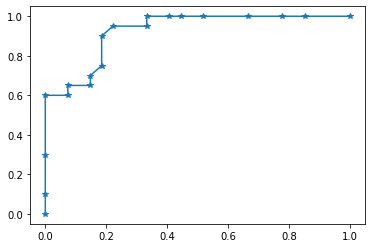

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_0, model_0.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, marker = '*')

In [ ]:
model_05 = BalancedRandomForestClassifier(n_estimators = 100,max_depth=13, max_features = 0.6, oob_score = False, warm_start = False, n_jobs = -1, class_weight = 'balanced_subsample')
model_05.fit(X_train, y_train_05)
pickle.dump(model_05, open('/content/drive/MyDrive/DS2- Project/OASIS 1/model_05.pkl', 'wb'))

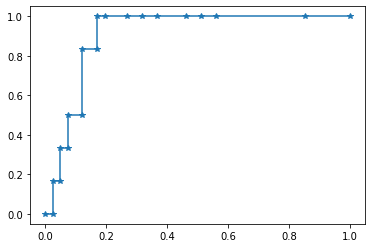

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_05, model_05.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr, marker = '*')

In [ ]:
model_1 = DecisionTreeClassifier(max_depth= 4, max_features= 4, class_weight= {0: 1, 1: 100}, min_samples_leaf= 4)
model_1.fit(X_train_1_s, y_train_1_s)

pickle.dump(model_1, open('/content/drive/MyDrive/DS2- Project/OASIS 1/model_1.pkl', 'wb'))

prob of 0 = 1 - prob of model_0
<br/>prob of 0.5 = prob of model_0 - prob of model_05
<br/>prob of 1 = prob of model_05 - prob of model_1
<br/>prob of 2 = prob of model_1

In [ ]:
def ord_model_predictions(X):

  classes_array = np.array(['Non demented', 'very mild', 'mild', 'moderate'])
  probs_model_0 = model_0.predict_proba(X)[:,1]
  probs_model_05 = model_05.predict_proba(X)[:,1] - 0.15
  probs_model_1 = model_1.predict_proba(X)[:,1]

  class0_probs = 1 - probs_model_0
  class05_probs = probs_model_0 - probs_model_05 
  class1_probs = probs_model_05 - probs_model_1 
  class2_probs = probs_model_1

  probs = np.concatenate([class0_probs.reshape(-1,1),class05_probs.reshape(-1,1), class1_probs.reshape(-1,1), class2_probs.reshape(-1,1)], axis = 1)
  
  predictions = classes_array[np.argmax(probs, axis = 1)]
  return predictions

In [ ]:
print(f"The accuracy on train is {accuracy_score(y_train, ord_model_predictions(X_train)):.2f}")

The accuracy on train is 0.91


In [ ]:
print(f"The accuracy on test is {accuracy_score(y_test, ord_model_predictions(X_test)):.2f}")

The accuracy on test is 0.62


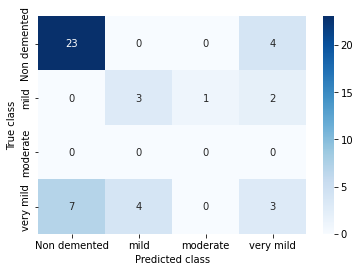

In [ ]:
sns.heatmap(pd.DataFrame(data = confusion_matrix(y_test, ord_model_predictions(X_test)), columns = np.unique(ord_model_predictions(X_test)), index =  np.unique(ord_model_predictions(X_test))),cmap='Blues', annot =True, fmt='')

plt.xlabel("Predicted class")
plt.ylabel('True class')
plt.show()

# Explaining the model predictions

Among the ordinal model and the Adaboost model, we will be choosig Adaboost to explain the model's predictions since it is compatable with sklearn.

## Feature importance

Permutation importance

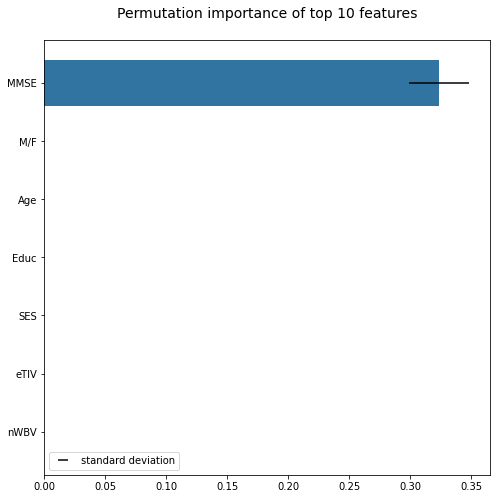

In [ ]:
importances_dict = permutation_importance(best_model, X_test, y_test)
importances_mean_sorted, importances_std_sorted, feature_labels_sorted = zip(*sorted(list(zip(importances_dict['importances_mean'],importances_dict['importances_std'] ,X_test.columns.tolist())), key=lambda x: -x[0]))

fig = plt.figure(figsize = (8,8))

sns.barplot(y = list(feature_labels_sorted)[:10], x = list(importances_mean_sorted)[:10], orient='h')
plt.errorbar(y = feature_labels_sorted[:10],x = importances_mean_sorted[:10], xerr = importances_std_sorted[:10], color = 'black', fmt='none', label = 'standard deviation' )

plt.title('Permutation importance of top 10 features\n', fontsize = 14)
plt.legend()
plt.show()

MMSE seems to be the most important feature to the model while predicint `cdr`. This seems reasonable since `MMSE` indicates the cognitive health of an individual.

## LIME

In [ ]:
# pip install lime

In [ ]:
import lime
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
X_train.head()

M/F  Age  Educ  SES  MMSE  eTIV   nWBV
272    0   90   3.0  2.0  28.0  1495  0.761
23     0   58   5.0  1.0  30.0  1235  0.820
352    0   77   2.0  4.0  22.0  1350  0.736
286    0   72   4.0  2.0  22.0  1493  0.690
32     0   84   3.0  2.0  28.0  1402  0.695

In [ ]:
y_test.shape

(47,)

In [ ]:
explainer = LimeTabularExplainer(X_train.values,
                                 feature_names=X_train.columns,
                                 class_names = y_train.unique().tolist(),
                                 mode='classification')

idx = 18

exp = explainer.explain_instance(X_test.values[idx], 
                                 best_model.predict_proba,
                                 num_features = 10)


exp.show_in_notebook(show_table=True, show_all=False)

print(f"\nModel prediction :{best_model.predict(X_test.iloc[idx, :].to_frame().T)}")
print(f"True class: {y_test.values[idx]}")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"



Model prediction :['mild']
True class: mild


In [ ]:
X_test.iloc[idx, :].to_frame().T

M/F   Age  Educ  SES  MMSE    eTIV   nWBV
385  0.0  78.0   1.0  4.0  23.0  1461.0  0.715

The model prediction for the above observation is correct. We can observe from the plot above that the most contribution for prediction of `mild` dementia is from `MMSE` being less than 26.

Since, we know that MMSE will have a major impact on calculating cdr of an individual, we can trust the models prediction for this observation.

In [ ]:
idx = 25

exp = explainer.explain_instance(X_test.values[idx], 
                                 best_model.predict_proba,
                                 labels = (3,),
                                 num_features = 10)


exp.show_in_notebook(show_table=True, show_all=False)

print(f"\nModel prediction :{best_model.predict(X_test.iloc[idx, :].to_frame().T)}")
print(f"True class: {y_test.values[idx]}")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"



Model prediction :['Non demented']
True class: very mild


In [ ]:
X_test.iloc[idx, :].to_frame().T

M/F   Age  Educ  SES  MMSE    eTIV   nWBV
378  1.0  74.0   5.0  2.0  28.0  1659.0  0.747

Our model predicted the above observation as `Non demented` while the true class is `very mild`. 

Upon looking at the Lime plot above, we can say that for this prediction, having `MMSE` score between 26 and 28 is contributing towards the `moderate` cdr class. This does not make sense, so we can choose not to trust this prediction.